# Проект: Предсказание успешности стартапа

## О проекте


__Цель проекта__:

- Разработать модель машинного обучения для предсказания успешности стартапа.
- Провести полноценный разведочный анализ и сформировать рекомендации будущим создателям стартапов (какие факторы влияют на успешность стартапа).

__Описание данных__:

Датасет состоит из двух файлов: тренировочный набор (около 53к записей) и тестовый набор (около 13к записей). Тренировочный набор содержит целевой признак status, указывающий на то, закрылся стартап или продолжает действовать. Временной период - '1970-01-01' по '2018-01-01'. Дата формирования выгрузки - '2018-01-01'. Задача - предсказать значение 'status'('operating', 'closed') для каждого стартапа из тестового датасета.

- kaggle_startups_train.csv
- kaggle_startups_test.csv

Дополнительно:
- kaggle_startups_sample_submit.csv - файл с примером предсказаний в правильном формате

## Подготовка к проекту



In [ ]:
#!pip install -q phik

In [ ]:
#!pip install -q catboost

In [ ]:
#!pip install -q shap

In [ ]:
# импортируем необходимые библиотеки
import time
import warnings

import numpy as np
import pandas as pd
from matplotlib.cbook import boxplot_stats
import matplotlib.pyplot as plt
import seaborn as sns

from phik import phik_matrix
from phik.report import plot_correlation_matrix

from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler,\
 MinMaxScaler, MultiLabelBinarizer
from sklearn.tree import DecisionTreeClassifier

from catboost import CatBoostClassifier, Pool
import missingno as msno
import shap

# настройки
warnings.filterwarnings("ignore", category=UserWarning)

pd.set_option('display.float_format', '{:,.3f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# константы
EXPORT_DATE = pd.to_datetime('2018-01-01')

TITLE_SIZE = 18
LABEL_SIZE = 16

RANDOM_STATE = 42
TEST_SIZE = 0.2
RANDOM_SEED = 123
NUMBER_OF_CLUSTERS=40

## Загрузка и ознакомление с данными

In [ ]:
def show_info(df):
    """
    Функция выводит на экран информацию о датафрейме,
    первые 5 строк датафрейма и матрицу пропущенных значений.

    Args:
        df (DataFrame) - Датафрейм.
    """
    display(df.head())
    df.info()
    msno.matrix(df)

Загрузим тренировочный и тестовый наборы данных из csv-файлов, при загрузке распарсим даты. Также изучим образец, на котором нужно получить результат для kaggle.

In [ ]:
try:
    data_train = pd.read_csv(
        '/content/kaggle_startups_train.csv',
        parse_dates=['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at'])
except:
    print('Файл kaggle_startups_train.csv не найден')

In [ ]:
try:
    data_test = pd.read_csv(
        '/content/kaggle_startups_test.csv',
        parse_dates=['first_funding_at', 'last_funding_at'])
except:
    print('Файл kaggle_startups_test.csv не найден')

In [ ]:
try:
    sample_submit = pd.read_csv('/content/kaggle_startups_sample_submit.csv')
except:
    print('Файл kaggle_startups_sample_submit_28062024.csv не найден')

Изучим информацию о тренировочном датасете.

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,"828,626.000",operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT
1,EarLens,Manufacturing|Medical|Medical Devices,"42,935,019.000",operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT
2,Reviva Pharmaceuticals,Biotechnology,"35,456,381.000",operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT
3,Sancilio and Company,Health Care,"22,250,000.000",operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52515 non-null  object        
 1   category_list      50051 non-null  object        
 2   funding_total_usd  42447 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       47014 non-null  object        
 5   state_code         45753 non-null  object        
 6   region             46157 non-null  object        
 7   city               46157 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datetime64[ns]
 12  closed_at          4917 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory 

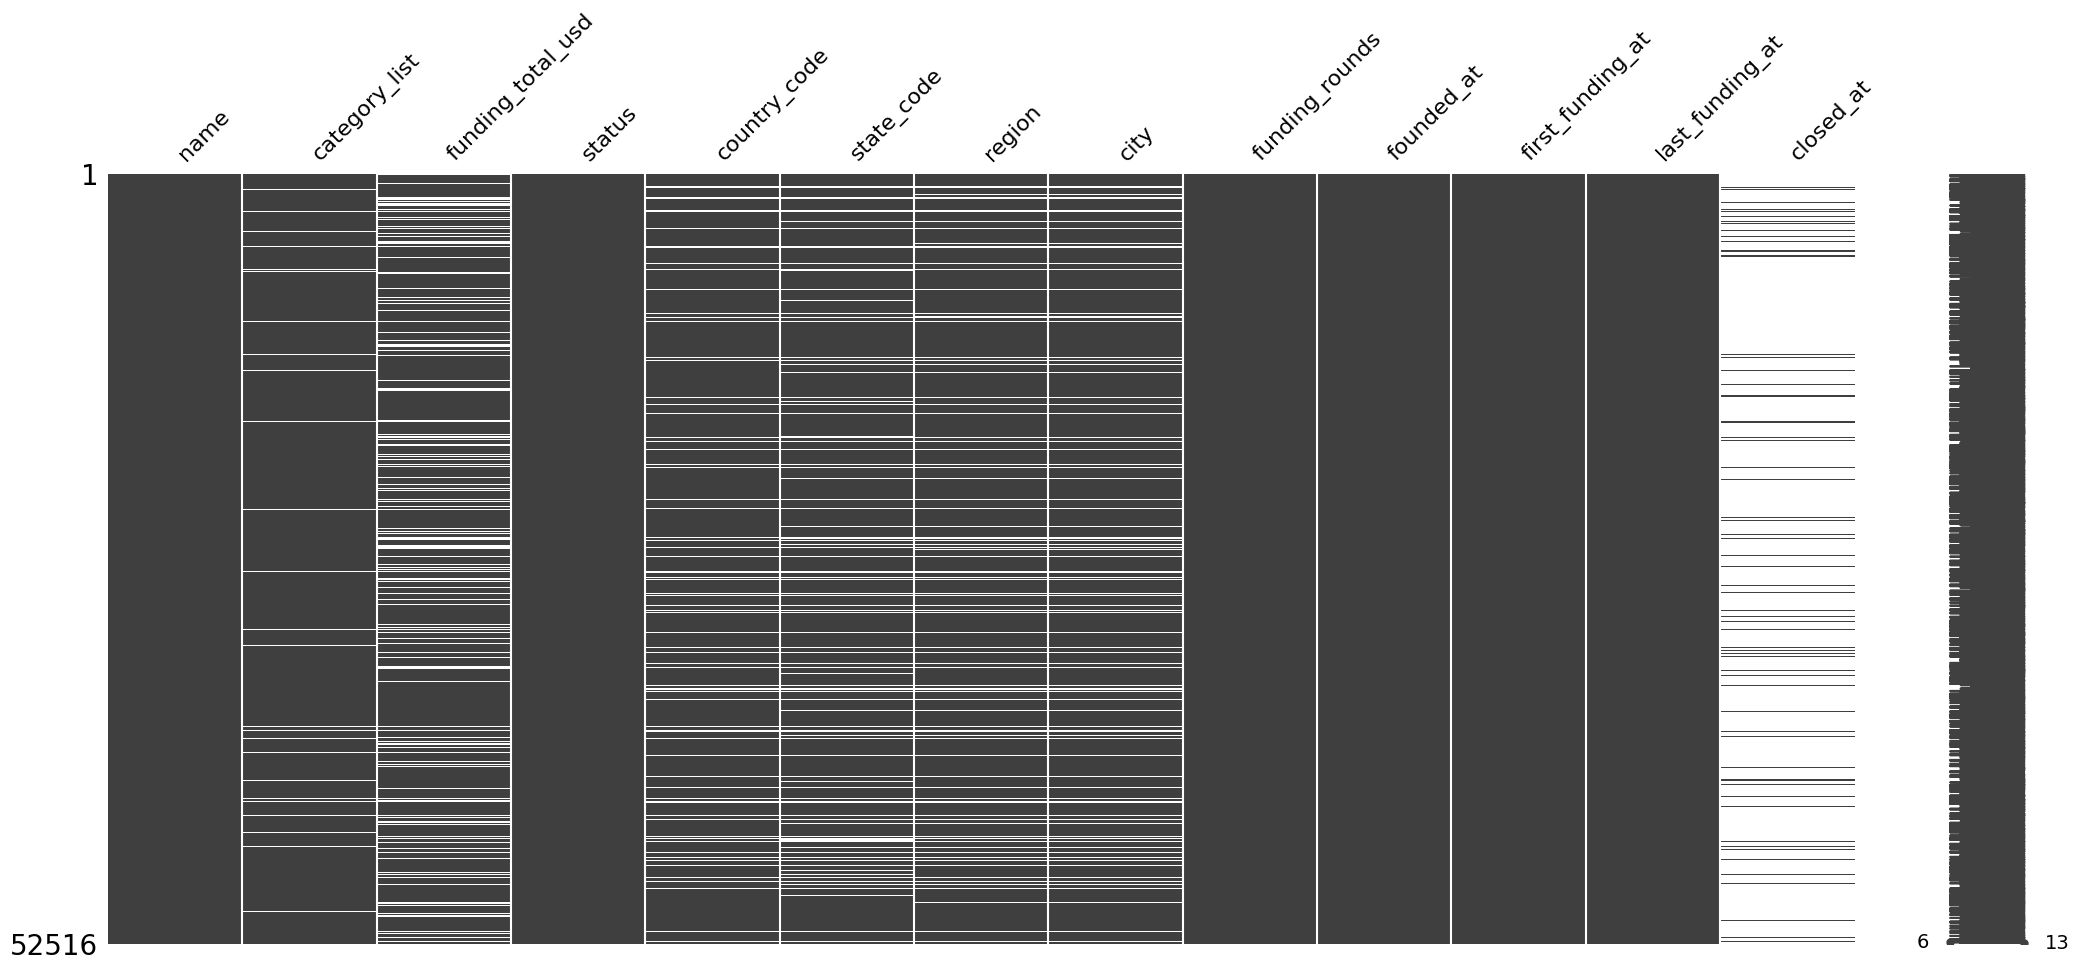

In [ ]:
show_info(data_train)

In [ ]:
# посмотрим на временной диапазон для даты основания
display(data_train['founded_at'].min(), data_train['founded_at'].max())

Timestamp('1970-02-05 00:00:00')

Timestamp('2016-04-02 00:00:00')

In [ ]:
# посмотрим на  временной диапазон для даты закрытия
display(data_train['closed_at'].min(), data_train['closed_at'].max())

Timestamp('1983-10-06 00:00:00')

Timestamp('2017-10-21 00:00:00')

Тренировочный набор содержит 52516 записей. Названия столбцов соответствуют змеиному регистру. Присутствуют пропуски, не наблюдается закономерности в их распределении. Данные соответствуют описанию. В таргете(`status`) пропусков нет. Столбец `lifetime` отсутствует.

Посмотрим на данные о тестовом датасете.

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,"2,819,200.000",NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,"428,257.000",LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,"34,700,000.000",USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,"4,530,000.000",CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      12534 non-null  object        
 2   funding_total_usd  10547 non-null  float64       
 3   country_code       11743 non-null  object        
 4   state_code         11430 non-null  object        
 5   region             11536 non-null  object        
 6   city               11538 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(6)
memory usage: 1.1+ MB


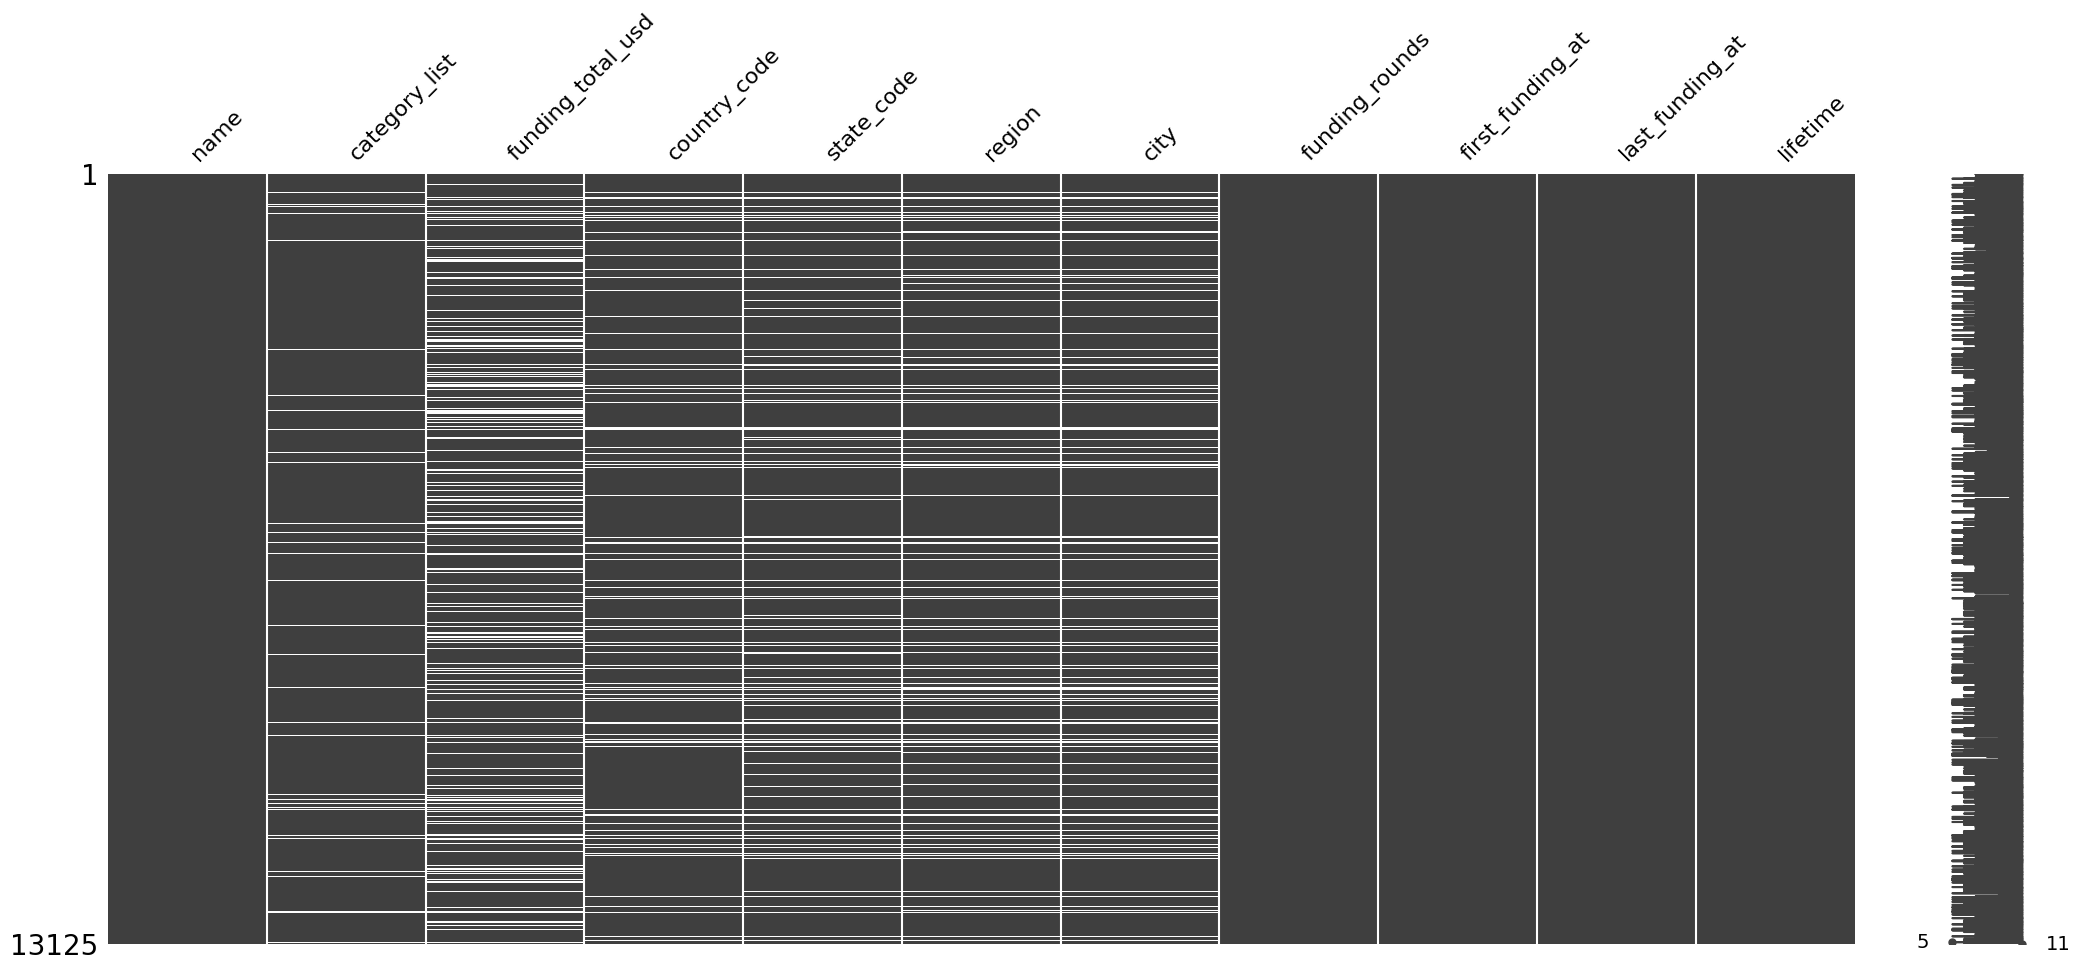

In [ ]:
show_info(data_test)

Тестовый набор содержит 13125 записей. Названия столбцов соответствуют змеиному регистру. Не наблюдается закономерности в распределении пропусков. Данные соответствуют описанию. Столбцы `status`, `founded_at`, `closed_at` отсутствуют, но есть столбец `lifetime`.

Посмотрим на образец.

In [ ]:
sample_submit.head()


,name,status
0,Crystalsol,closed
1,JBI Fish & Wings,operating
2,COINPLUS,closed
3,Imagine Communications,closed
4,DNA13,operating


__Промежуточный вывод__:
- загрузили тренировочный и тестовый датасеты, распарсили даты;
- данные соответствуют описанию, названия столбцов записаны в змеином регистре;
- в данных есть пропуски;
- есть различие в данных: в тренировочном датасете есть поля `founded_at`, `closed_at`, `status`, а в тестовом - `lifetime`;
- изучили образец результата, дополнительных преобразований с названиями стартапов делать не нужно.

## Предобработка данных

Выполним предобработку и очистку тренировочных данных. В этом и следующем разделах параллельно тренировочному будем предобрабатывать и тестовый датасет.

In [ ]:
# создадим копию датасета для контроля изменения размерности
data_train_check = data_train.copy()

### Дубликаты

Проверим наличие полных дубликатов и дубликатов по названию и дате создания стартапа.

In [ ]:
data_train.duplicated().sum()


0

In [ ]:
data_train.duplicated(subset=['name', 'founded_at']).sum()

0

Поработаем с текстовыми значениями. Повторим проверку на дубликаты.

In [ ]:
def normalize_categories(category_list):
    """
    Функция для обработки списка категорий в строке category_list.
    Выполняет удаление крайних пробелов вокруг каждой категории,
    приведение названий к нижнему регистру и сортировку.

    Args:
        category_list (str): Строка с категориями, разделенными символом '|'.
    Returns:
        Нормализованная строка категорий.
    """
    if pd.isna(category_list): # обработка NaN
        return category_list

    categories = category_list.split('|')
    categories = [cat.strip().lower() for cat in categories]
    categories.sort()
    return '|'.join(categories)

data_train['category_list'] = (
    data_train['category_list'].apply(normalize_categories))
data_test['category_list'] = (
    data_test['category_list'].apply(normalize_categories))

In [ ]:
def normalize_string_column(dataframe, columns):
    """
    Функция выполняет преобразование строковых значений в столбцах
    в верхний регистр и удаление крайних пробелов.

    Args:
        dataframe (DataFrame): Датафрейм.
        columns (list): Cписок названий очищаемых столбцов.
    """
    for column in columns:
        if column in dataframe.columns:
            dataframe[column] = dataframe[column].str.upper().str.strip()

columns_to_normalize = ['country_code', 'state_code', 'region', 'city']
normalize_string_column(data_train, columns_to_normalize)
normalize_string_column(data_test, columns_to_normalize)

In [ ]:
data_train.duplicated().sum()

0

### Пропуски


Проанализируем пропуски в данных.

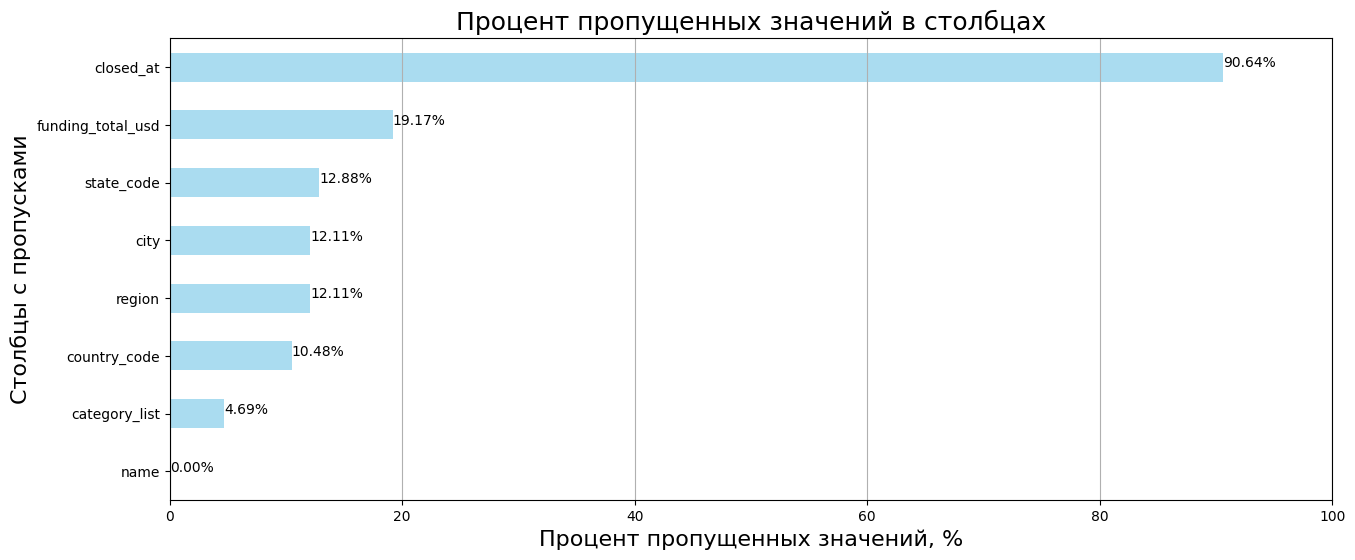

In [ ]:
ax = (
    (data_train.isna().mean() * 100)
    .to_frame()
    .rename(columns={0: 'percentage_of_missing_values'})
    .query('percentage_of_missing_values > 0')
    .sort_values(by='percentage_of_missing_values')
    .plot(kind='barh', color='skyblue', alpha=0.7, figsize=(15, 6),
          legend=False, xlim=(0, 100))
)

for p in ax.patches:
    ax.annotate(f'{p.get_width():.2f}%', ((p.get_width()),
                                          p.get_y() + p.get_height() / 2))
plt.title('Процент пропущенных значений в столбцах', fontsize=TITLE_SIZE)
plt.xlabel('Процент пропущенных значений, %', fontsize=LABEL_SIZE)
plt.ylabel('Столбцы c пропусками', fontsize=LABEL_SIZE)
plt.grid(axis='x')
plt.show()

Пропусков в целевом признаке нет. Большое количество пропусков в столбце `closed_at` (дата закрытия стартапа), однако нам он не понадобится для обучения модели, т.к. это утечка данных, происходит явная отсылка к целевому признаку. В названиях стартапов было всего одно пропущенное значение.

Рассмотрим пропуски в списке категорий.

In [ ]:
# распределение таргета среди записей с пропусками в списке категорий
(
    data_train[data_train['category_list'].isna()]
    .groupby('status')
    .agg(count = ('founded_at', 'count'))
)

,count
status,
closed,729
operating,1736


In [ ]:
# доля закрытых стартапов среди тех, у которых пропущено значение списка категорий
(
    data_train[
        (data_train['status'] == 'closed') & (data_train['category_list'].isna())]
    .shape[0]/data_train[data_train['category_list'].isna()].shape[0]
)

0.2957403651115619

In [ ]:
# распределение таргета среди записей без пропусков в списке категорий()
(
    data_train[~data_train['category_list'].isna()]
    .groupby('status')
    .agg({'founded_at': 'count'})
)

,founded_at
status,
closed,4188
operating,45863


In [ ]:
# доля закрытых стартапов среди тех, у которых есть значение списка категорий
(
    data_train[
        (data_train['status'] == 'closed') & (~data_train['category_list'].isna())]
    .shape[0]/data_train[~data_train['category_list'].isna()].shape[0]
)

0.08367465185510779

In [ ]:
# доля закрытых стартапов от общего числа
data_train[data_train['status'] == 'closed'].shape[0]/data_train.shape[0]

0.09362860842409933

На данном этапе выбираем стратегию заполнения пропусков в данном признаке значением по умолчанию `unknown`. При анализе результатов будем учитывать, что создается новая категорию с самым высоким процентом закрытия (29.6%). Сложно предложить другую логику для заполнения пропусков в этом признаке.

Изучим пропуски в данных о местоположении стартапа.

In [ ]:
# матрица корреляции пропущенных значений для данных о расположении стартапа
data_train[['country_code', 'state_code', 'region', 'city']].isnull().corr()

,country_code,state_code,region,city
country_code,1.000,0.890,0.922,0.922
state_code,0.890,1.000,0.925,0.925
region,0.922,0.925,1.000,1.000
city,0.922,0.925,1.000,1.000


In [ ]:
# количество записей с полными данными о расположении
data_train[
    data_train['country_code'].notna() &
    data_train['state_code'].notna() &
    data_train['region'].notna() &
    data_train['city'].notna()
].shape[0]

45519

In [ ]:
# количество записей, у которых отсутствуют все данные о расположении
data_train[
    data_train['country_code'].isna() &
    data_train['state_code'].isna() &
    data_train['region'].isna() &
    data_train['city'].isna()
].shape[0]

5502

Довольно часто пропуски в столбцах `country_code`, `state_code`, `region`, `city` наблюдаются одновременно. Удалять эти строки не будем, т.к. можем потерять много данных.

Для категориальных переменных (`name`, `country_code`, `state_code`, `region`, `city`) заполняем пропуски значением по умолчанию "unknown". Пропуски в 'funding_rounds' заполним медианой. Пропуски в поле 'funding_total_usd' заполним медианнным значением для записей с таким же количеством раундов, пропуски в датах - средним значением.

In [ ]:
def replace_missing_values(df, columns_to_replace_with_unknown, columns_to_replace_with_median, columns_to_replace_with_mean):
    """
    Функция для заполнения пропущенных значений в столбцах:
    - значением по умолчанию "unknown"
    - медианным значением
    - средним значением
    в соответствии с переданными списками.
    Пропуски в столбце funding_total_usd заполняются
    медианой по группе funding_rounds.

    Args:
        df (DataFrame) :  Датафрейм.
        columns_to_replace_with_unknown (list) : список столбцов для заполнения
            значением по умолчанию "unknown"
        columns_to_replace_with_median (list) : список столбцов для заполнения
          медианой
        columns_to_replace_with_mean (list) : список столбцов для заполнения
          средним

    Returns:
        Датафрейм.
    """

    for column in columns_to_replace_with_unknown:
        df[column] = df[column].fillna('unknown')

    for column in columns_to_replace_with_median:
        df[column] = df[column].fillna(df[column].median())

    for column in columns_to_replace_with_mean:
        df[column] = df[column].fillna(df[column].mean())

    # Заполнение пропусков в funding_total_usd
    # на основе медианы по группе funding_rounds
    df.loc[:, 'funding_total_usd'] = (
         df.groupby('funding_rounds')['funding_total_usd']
         .transform(lambda x: x.fillna(x.median())))

    return df

In [ ]:
columns_to_replace_with_unknown = ['name', 'country_code', 'state_code',
                                   'category_list', 'region', 'city']
columns_to_replace_with_median = ['funding_rounds']
columns_to_replace_with_mean = ['first_funding_at', 'last_funding_at']

data_train = replace_missing_values(data_train,
                                    columns_to_replace_with_unknown,
                                    columns_to_replace_with_median,
                                    columns_to_replace_with_mean)
data_test = replace_missing_values(data_test,
                                    columns_to_replace_with_unknown,
                                    columns_to_replace_with_median,
                                    columns_to_replace_with_mean)

In [ ]:
data_train.isna().sum()

,0
name,0
category_list,0
funding_total_usd,0
status,0
country_code,0
state_code,0
region,0
city,0
funding_rounds,0
founded_at,0


### Проверка значений таргета

Проверим значения таргета.

In [ ]:
data_train['status'].unique()

array(['operating', 'closed'], dtype=object)

Присутствуют только два значения, ошибок нет.

### Добавление столбцов

Т.к. в тестовом датасете отсутствует признак 'founded_at', но появляется признак `lifetime`, добавим такой столбец к нашим тренировочным данным.

In [ ]:
# изучим уникальные значения столбца closed_at
data_train['closed_at'].unique()

<DatetimeArray>
[                'NaT', '2015-07-10 00:00:00', '2015-08-11 00:00:00',
 '2014-09-04 00:00:00', '2016-11-03 00:00:00', '2001-12-28 00:00:00',
 '2014-04-26 00:00:00', '2013-08-07 00:00:00', '2012-02-26 00:00:00',
 '2014-06-09 00:00:00',
 ...
 '2012-10-13 00:00:00', '2009-06-18 00:00:00', '2009-05-06 00:00:00',
 '2017-03-30 00:00:00', '2015-12-24 00:00:00', '2014-08-21 00:00:00',
 '2017-03-24 00:00:00', '2002-05-17 00:00:00', '2014-05-04 00:00:00',
 '2007-03-05 00:00:00']
Length: 3009, dtype: datetime64[ns]

Значение NaT означает, что присутствовал пропуск либо значение не удалось преобразовать в дату.

In [ ]:
# убедимся, что NaT в closed_at соответствует компаниям, продолжающим работать
data_train[data_train['status'] == 'operating']['closed_at'].unique()

<DatetimeArray>
['NaT']
Length: 1, dtype: datetime64[ns]

Добавим столбец `lifetime`.

In [ ]:
def calculate_lifetime(row):
    """
    Функция возвращает время жизни компании в днях, используя правила:
    - разность в днях между датой закрытия и датой основания,
     если компания закрылась,
    - разность в днях между датой формирования выгрузки и датой основания,
     если компания продолжает работать.
    В функции используется константа EXPORT_DATE - дата формирования выгрузки.

    Args:
        row : строка DataFrame, содержащая данные о компании
    Return:
        Время жизни компании в днях.
    """

    if row['status'] == 'closed':
        return (row['closed_at'] - row['founded_at']).days
    else:
        return (EXPORT_DATE - row['founded_at']).days

In [ ]:
data_train['lifetime'] = data_train.apply(calculate_lifetime, axis=1)

In [ ]:
# убедимся, что все значения вычислены
data_train['lifetime'].isna().sum()

0

На случай, если в тестовом датасете есть пропуски в столбце `lifetime`, заполним их медианой.

In [ ]:
data_test['lifetime'] = data_test['lifetime'].fillna(data_test['lifetime'].median())

Также добавим еще один признак - среднее значение финансирования, полученного за один раунд.

In [ ]:
data_train['mean_funding_per_round'] = (
    data_train['funding_total_usd'] / data_train['funding_rounds'])
data_test['mean_funding_per_round'] = (
    data_test['funding_total_usd'] / data_test['funding_rounds'])

__Промежуточный вывод__:
- выполнили проверку на дубликаты,
- нормализовали текстовые значения (значения в списке категорий отсортировали, записали в нижнем регистре, удалили крайние пробелы, значения местоположения стартапов записали в верхнем регистре, удалили крайние пробелы), повторили поиск дубликатов,
- изучили пропуски, заполнили пропуски для категориальных данных `name`, `country_code`, `state_code`, `region`, `city` значением по умолчанию "unknown",пропуски в `funding_total_usd` - медианой, в датах - средним (на случай их наличия в тестовом датасете). Пропуски в поле `funding_total_usd` заполним медианнным значением для записей с таким же количеством раундов.
- создали столбец `lifetime` в тренировочном датасете, `mean_funding_per_round` в обоих датасетах,
- определили, что в столбце `closed_at` происходит утечка данных.

## Исследовательский анализ данных

### Таргет

Рассмотрим целевой признак - `status` (статус стартапа).

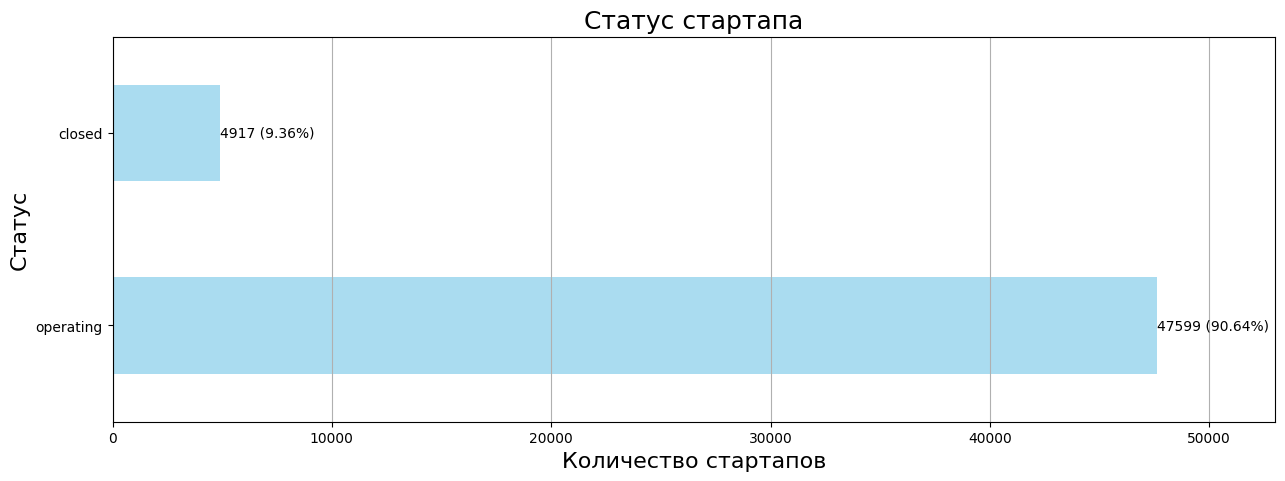

In [ ]:
value_counts = data_train['status'].value_counts()
percentages = (value_counts / len(data_train)) * 100
status_counts = pd.DataFrame({'count': value_counts, 'percentage': percentages})

# Построение графика
plt.figure(figsize=(15, 5))
status_counts['count'].plot(kind='barh', color='skyblue', alpha=0.7)

# Добавление подписей с числами и процентами
for index, value in enumerate(status_counts['count']):
    plt.text(value + 0.05, index,
             f"{value} ({status_counts['percentage'].iloc[index]:.2f}%)",
             va='center')

plt.title('Статус стартапа', fontsize=TITLE_SIZE)
plt.xlabel('Количество стартапов', fontsize=LABEL_SIZE)
plt.ylabel('Статус', fontsize=LABEL_SIZE)
plt.grid(axis='x')
plt.xlim(0, 53000)
plt.show()

Наблюдается дисбаланс классов в целевом признаке. В нашей выборке 9.36% стартапов закрыты, 90.64% - действующие.

### Названия компаний

In [ ]:
data_train['name'].nunique()

52516

Названия стартапов уникальны. Признак `name` в рамках нашей модели учитывать не будем.

### Финансирование

In [ ]:
def analyze_numerical_data(data, column, title, bins_number=100):
    """
    Функция помогает при проведении статистического анализа количественных
     признаков.

    Принимает датасет, столбец для анализа и значение заголовка для вывода графика.
    Может принимать bins для построения графика.

    Выводит для колонки:
    - гистограмму с отмеченным средним значением и медианой
    - диаграмму размаха
    """

    median = data[column].median()
    mean = data[column].mean()

    # Создаем фигуру и оси для гистограммы
    fig, ax = plt.subplots(2, 1, figsize=(17, 10))

    # Гистограмма
    ax[0].hist(data[column], bins=bins_number, color='skyblue')
    ax[0].set_title(f'Гистограмма для признака "{title}"', fontsize=TITLE_SIZE)
    ax[0].set_xlabel(title, fontsize=LABEL_SIZE)
    ax[0].set_ylabel('Частота', fontsize=LABEL_SIZE)
    ax[0].grid(True)

    ax[0].axvline(median, color='green', linestyle='dashed', linewidth=1.5,
                  label=f'Медиана: {median:.2f}')
    ax[0].axvline(mean, color='red', linestyle='dashed', linewidth=1.5,
                  label=f'Среднее: {mean:.2f}')
    ax[0].legend()

    # Диаграмма размаха
    ax[1] = data[[column]].boxplot(vert=False, ax=ax[1])
    ax[1].set_title(f'Диаграмма размаха для признака "{title}"',
                    fontsize=TITLE_SIZE)

    plt.tight_layout()
    # Установка вертикального отступа между графиками
    plt.subplots_adjust(hspace=0.3)
    plt.show()

Рассмотрим признак funding_total_usd - общая сумма финансирования в USD.

In [ ]:
data_train['funding_total_usd'].describe()

,funding_total_usd
count,"52,516.000"
mean,"14,978,122.113"
std,"168,361,283.423"
min,1.000
25%,"529,721.250"
50%,"1,021,239.000"
75%,"7,000,000.000"
max,"30,079,503,000.000"


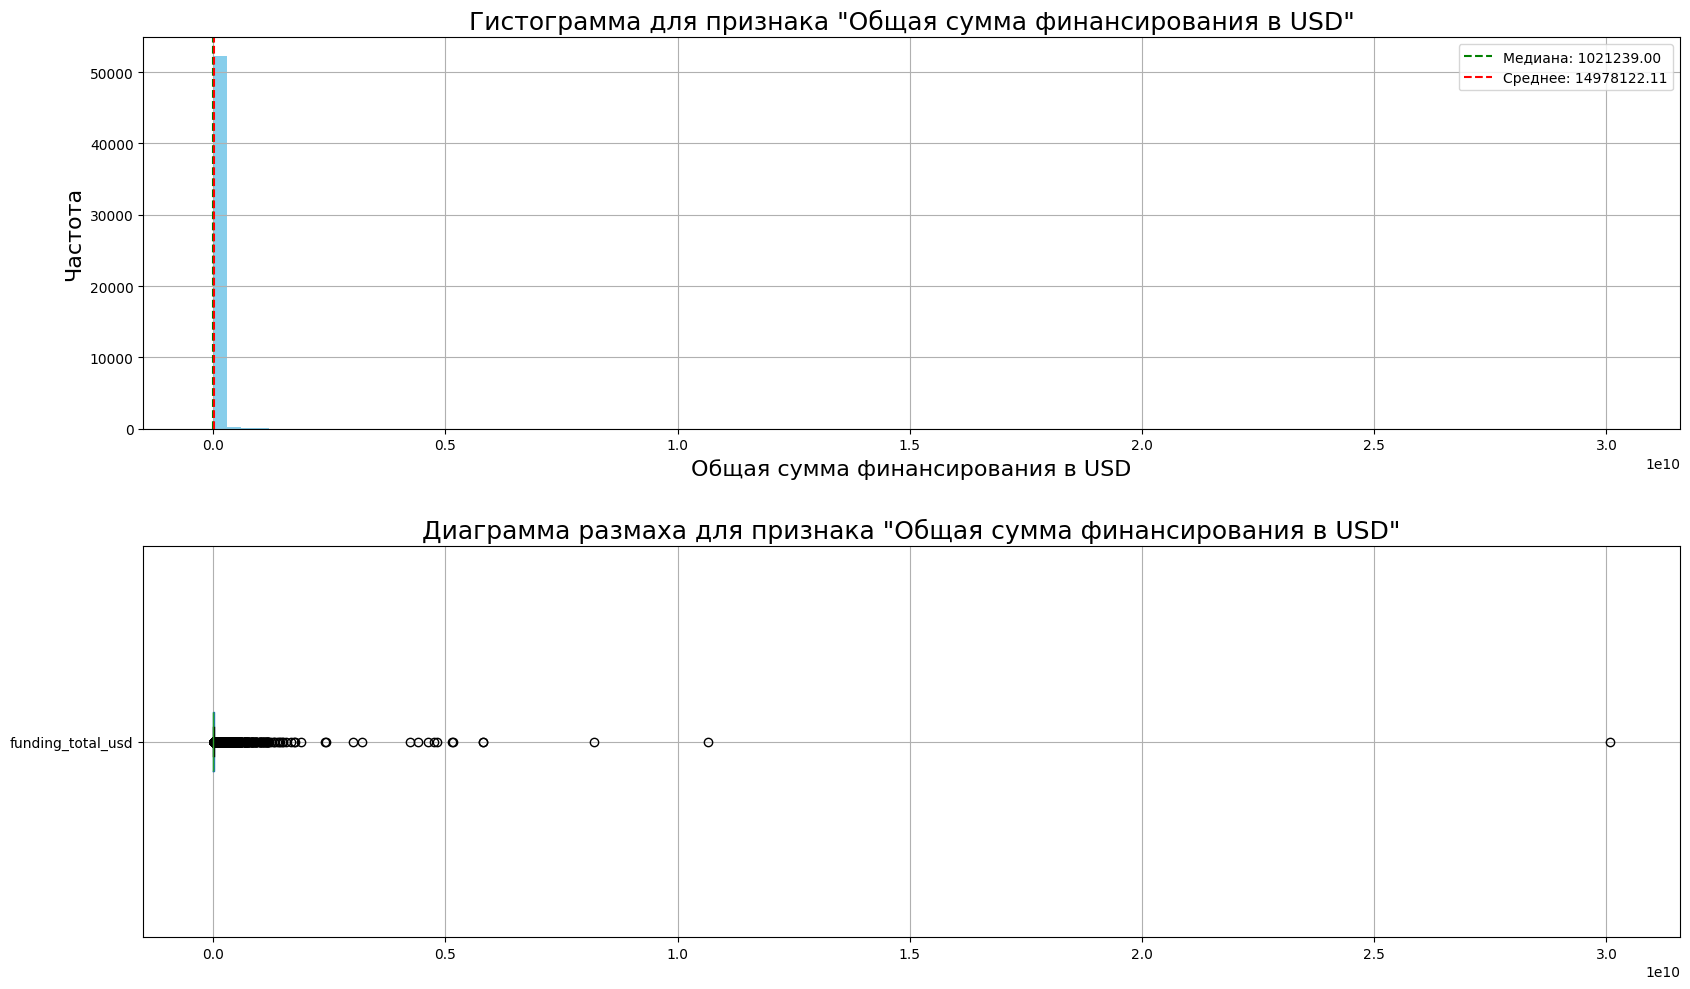

In [ ]:
analyze_numerical_data(data_train, 'funding_total_usd', 'Общая сумма финансирования в USD')

Значения распределены в диапазоне от 1 до 30 079 503. Границы межквартильного размаха - от 529 721.25 до 7,000,000. Медианное значение - 1 021 239, среднее намного превышает его - 14 978 122.113. Стандартное отклонение - 168 361 283.423. Присутствуют выбросы. Подберем допустимую границу для избежания больших потерь и удалим выбросы.

In [ ]:
# получим крайнее значение, которое не является выбросом
whishi = boxplot_stats(data_train['funding_total_usd'])[0]['whishi']
whishi

16701212.0

In [ ]:
data_train[data_train['funding_total_usd'] > whishi].shape[0]/data_train_check.shape[0]

0.14681240003046692

In [ ]:
(
    data_train[['funding_total_usd']]
    .quantile([ .85, .86, .87, .88, .90,.95, .98, .99])
    .style.format("{:,.2f}")
)

,funding_total_usd
0.850000,"16,000,000.00"
0.860000,"18,026,309.99"
0.870000,"20,000,000.00"
0.880000,"22,226,034.40"
0.900000,"27,928,437.50"
0.950000,"56,052,954.00"
0.980000,"113,470,000.00"
0.990000,"188,028,500.00"


In [ ]:
limit = data_train['funding_total_usd'].quantile(0.9)
data_train[data_train['funding_total_usd'] > limit].shape[0]/data_train_check.shape[0]

0.10000761672633102

Подобрали такую границу, чтобы потеря данных составляла не более 10%.

In [ ]:
data_train = (
    data_train[(data_train['funding_total_usd'] <= limit) | (data_train['funding_total_usd'].isna())])

In [ ]:
# контролируем изменение размера
data_train.shape[0]/data_train_check.shape[0]

0.8999923832736689

Взглянем на изменение описания признака после удаления дубликатов.

In [ ]:
data_train['funding_total_usd'].describe()

,funding_total_usd
count,"47,264.000"
mean,"3,534,501.005"
std,"5,559,262.804"
min,1.000
25%,"450,000.000"
50%,"860,000.000"
75%,"3,900,000.000"
max,"27,901,875.000"


Значения распределены в диапазоне от 1 до 27 901 875. Границы межквартильного размаха - от 450 000 до 3 900 000. Медианное значение - 860 000, среднее - 3 534 501.005. Стандартное отклонение - 5 559 262.804. Разброс данных значительно уменьшился.

Взглянем на тестовые данные.

In [ ]:
data_test['funding_total_usd'].describe()

,funding_total_usd
count,"13,125.000"
mean,"13,544,334.630"
std,"82,857,649.493"
min,1.000
25%,"501,000.000"
50%,"1,000,000.000"
75%,"6,840,683.000"
max,"4,715,000,000.000"


Среднее намного превышает медианное значение, что говорит о наличии аномально больших значений. Данные имеют широкий разброс.

Посмотрим на значения общей суммы финансирования в разрезе по статусам.

In [ ]:
data_train.groupby('status')['funding_total_usd'].describe()

,count,mean,std,min,25%,50%,75%,max
status,,,,,,,,
closed,"4,556.000","3,073,640.330","5,086,997.987",2.000,"300,000.000","860,000.000","3,000,000.000","27,671,780.000"
operating,"42,708.000","3,583,664.657","5,605,114.374",1.000,"472,576.750","860,000.000","4,000,000.000","27,901,875.000"


Средняя общая сумма финансирования у закрытых компаний меньше (3 073 640.330 против 3 583 664.657), в то время как медианные значения равны. Минимальная и максимальная общие суммы практически равны.

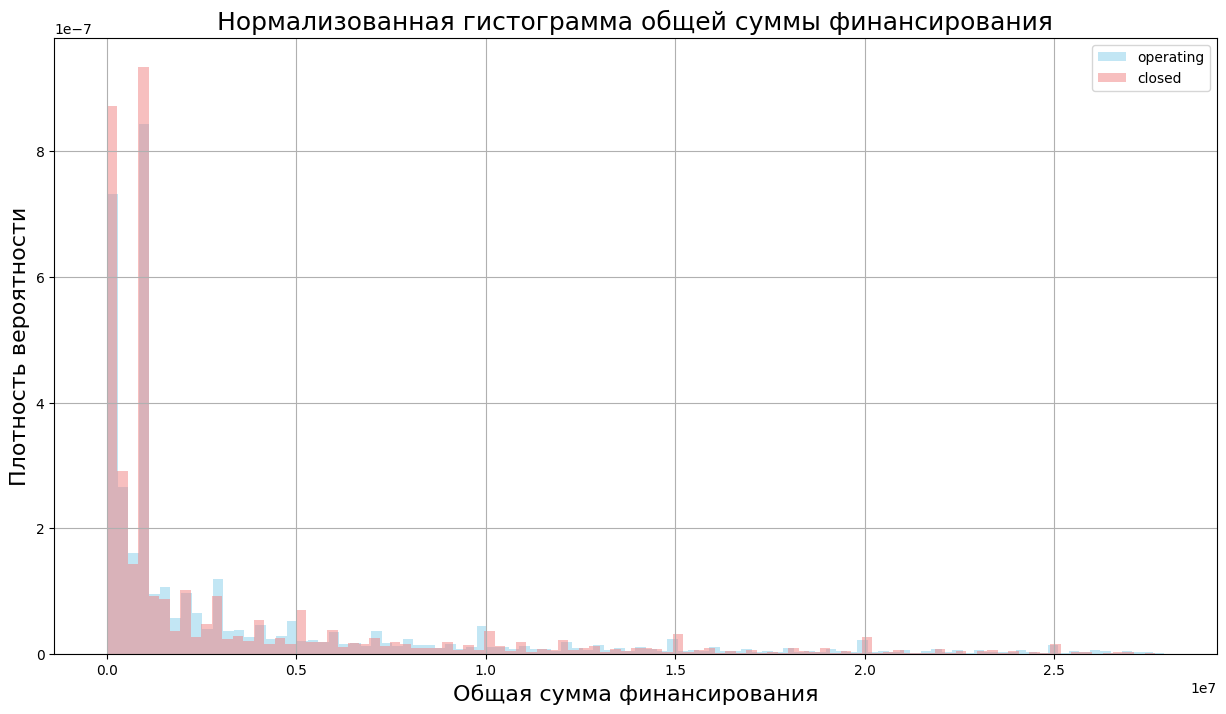

In [ ]:
plt.figure(figsize=(15, 8))

# Построение гистограммы для действующих стартапов
plt.hist(
    data_train[data_train['status'] == 'operating']['funding_total_usd'],
    bins=100, color='skyblue', alpha=0.5, label='operating', density=True)
# Построение гистограммы для закрытых стартапов
plt.hist(
    data_train[data_train['status'] == 'closed']['funding_total_usd'],
    bins=100, color='lightcoral', alpha=0.5, label='closed', density=True)

plt.title('Нормализованная гистограмма общей суммы финансирования',
          fontsize=TITLE_SIZE)
plt.xlabel('Общая сумма финансирования', fontsize=LABEL_SIZE)
plt.ylabel('Плотность вероятности', fontsize=LABEL_SIZE)
plt.legend()
plt.grid(True)
plt.legend()
plt.show()

Посмотрим на число раундов финансирования.

In [ ]:
data_train['funding_rounds'].value_counts(normalize=True)

,proportion
funding_rounds,
1,0.683
2,0.188
3,0.075
4,0.030
5,0.013
6,0.005
7,0.003
8,0.001
9,0.001


Большинство компаний прошли только через один раунд финансирования (68.3%), 2 раунда (18.8%) или 3 раунда (7.5%).

In [ ]:
data_train.groupby('status').agg({
    'funding_rounds': ['median', 'mean', 'min', 'max'],
})

funding_rounds              
                  median  mean min max
status                                
closed             1.000 1.313   1  11
operating          1.000 1.571   1  16

Среднее число раундов у действующих компаний незначительно больше, чем у закрытых. Медианные значения равны.

In [ ]:
filtered_data = (
    data_train
    .groupby('funding_rounds')
    .agg(
        total=('status', 'count'),
        operating=('status', lambda x: (x == 'operating').sum()),
        closed=('status', lambda x: (x == 'closed').sum()),
        share_of_closed=('status', lambda x: (x == 'closed').sum() / len(x))
    )
    .loc[lambda x: x['total'] > 100]  # Фильтрация по условию total > 100
    .sort_values(by='share_of_closed')
)
filtered_data

,total,operating,closed,share_of_closed
funding_rounds,,,,
5,610,588,22,0.036
4,1433,1377,56,0.039
3,3553,3389,164,0.046
7,125,119,6,0.048
6,258,245,13,0.050
2,8901,8229,672,0.075
1,32261,28647,3614,0.112


Учитывая только группы  по раундам, где число записей больше 100, наибольшая доля закрытий приходится на компании, прошедшие только 1 или 2 раунда финансирования (11.2% и 7.5% соответственно). Наименьшая  - у компаний, прошедших 5 раундов (3.6%).

### Категории

Рассмотрим столбец, содержащий список категорий, к которым относится стартап.

In [ ]:
# количество уникальных списков
data_train['category_list'].nunique()

20524

Узнаем количество уникальных категорий, которые упоминаются в category_list, если значение не пропущено.

In [ ]:
set_of_categories_train = (
    {category for category_list in data_train['category_list'].dropna().unique()
     for category in category_list.split('|')}
)
len(set_of_categories_train)

855

In [ ]:
set_of_categories_test = (
    {category for category_list in data_test['category_list'].dropna().unique()
    for category in category_list.split('|')}
)
len(set_of_categories_test)

796

In [ ]:
# количество новых уникальных категорий в тестовом датасете
len(set_of_categories_test - set_of_categories_train)

4

В столбце 'category_list' фигурируют 855 уникальных категорий.

Разделим уникальные категории на кластеры.

In [ ]:
# Разделим и объединим категории по строкам, чтобы каждая категория
# была представлена отдельно
categories_df = pd.DataFrame(set_of_categories_train, columns=['category'])
categories_df = categories_df.sort_values(by='category')

# Преобразуем категории в числовое представление с помощью TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(categories_df['category'])

# Подбираем количество кластеров и обучаем K-means
kmeans = KMeans(n_clusters=NUMBER_OF_CLUSTERS, random_state=RANDOM_STATE)
categories_df['cluster'] = kmeans.fit_predict(X)

# Сопоставим категории с их кластерами
clusters = categories_df.groupby('cluster')['category'].apply(list)
print("Распределение категорий по кластерам:")
for i, cluster in clusters.items():
    print(f"Кластер {i + 1}: {cluster}")

Распределение категорий по кластерам:
Кластер 1: ['geospatial']
Кластер 2: ['mobile video', 'online video advertising', 'video', 'video chat', 'video conferencing', 'video editing', 'video game tournaments', 'video games', 'video on demand', 'video processing', 'video streaming']
Кластер 3: ['b2b', 'b2b express delivery']
Кластер 4: ['casual games', 'educational games', 'games', 'mmo games', 'mobile games', 'serious games', 'social games']
Кластер 5: ['cloud-based music', 'independent music', 'independent music labels', 'music', 'music education', 'music services', 'music venues']
Кластер 6: ['cloud computing', 'cloud data services', 'cloud gaming', 'cloud management', 'cloud security', 'cyber security', 'data security', 'homeland security', 'information security', 'mobile security', 'network security', 'physical security', 'security']
Кластер 7: ['cloud infrastructure', 'communications infrastructure', 'data center infrastructure', 'infrastructure', 'infrastructure builders', 'interne

In [ ]:
# Создаем словарь для сопоставления категорий с их кластерами
category_to_cluster = dict(zip(categories_df['category'],
                               categories_df['cluster']))

def convert_category_to_cluster(row):
    set_of_categories_train = set(row['category_list'].split('|'))
    set_of_clusters = {category_to_cluster[category] \
                       for category in set_of_categories_train \
                       if category in category_to_cluster}
    return '|'.join(map(str, sorted(set_of_clusters)))

data_train['clusters_list'] = data_train.apply(convert_category_to_cluster,
                                               axis=1)
# Результат
data_train[['category_list', 'clusters_list']]

,category_list,clusters_list
0,online reservations|restaurants,15
3,health care,15
4,manufacturing,15
5,mobile,26
7,software,15
...,...,...
52511,entertainment,15
52512,hospitality,15
52513,email|messaging|productivity software,15|30
52514,security,5


In [ ]:
# найдем число уникальных списков кластеров
data_train['clusters_list'].nunique()

1752

In [ ]:
# Применение MultiLabelBinarizer
mlb = MultiLabelBinarizer()
data_train['clusters_list'] = data_train['clusters_list'].fillna('').str.split('|')
category_matrix = mlb.fit_transform(data_train['clusters_list'])

# Преобразуем в DataFrame
category_df = pd.DataFrame(category_matrix, columns=mlb.classes_)
# Соединяем с исходным DataFrame, сбросив индексы
data_train = data_train.reset_index(drop=True)
category_df = category_df.reset_index(drop=True)
data_train = pd.concat([data_train, category_df], axis=1)

In [ ]:
# удостоверимся, что столбцы присоединены
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47264 entries, 0 to 47263
Data columns (total 56 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   name                    47264 non-null  object        
 1   category_list           47264 non-null  object        
 2   funding_total_usd       47264 non-null  float64       
 3   status                  47264 non-null  object        
 4   country_code            47264 non-null  object        
 5   state_code              47264 non-null  object        
 6   region                  47264 non-null  object        
 7   city                    47264 non-null  object        
 8   funding_rounds          47264 non-null  int64         
 9   founded_at              47264 non-null  datetime64[ns]
 10  first_funding_at        47264 non-null  datetime64[ns]
 11  last_funding_at         47264 non-null  datetime64[ns]
 12  closed_at               4556 non-null   dateti

<ipython-input-72-5774cbda5367>:3: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  data_train.groupby('status')[names_of_clusters].agg(sum)
<ipython-input-72-5774cbda5367>:5: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  pivot_table = data_train.groupby('status')[names_of_clusters].agg(sum).T


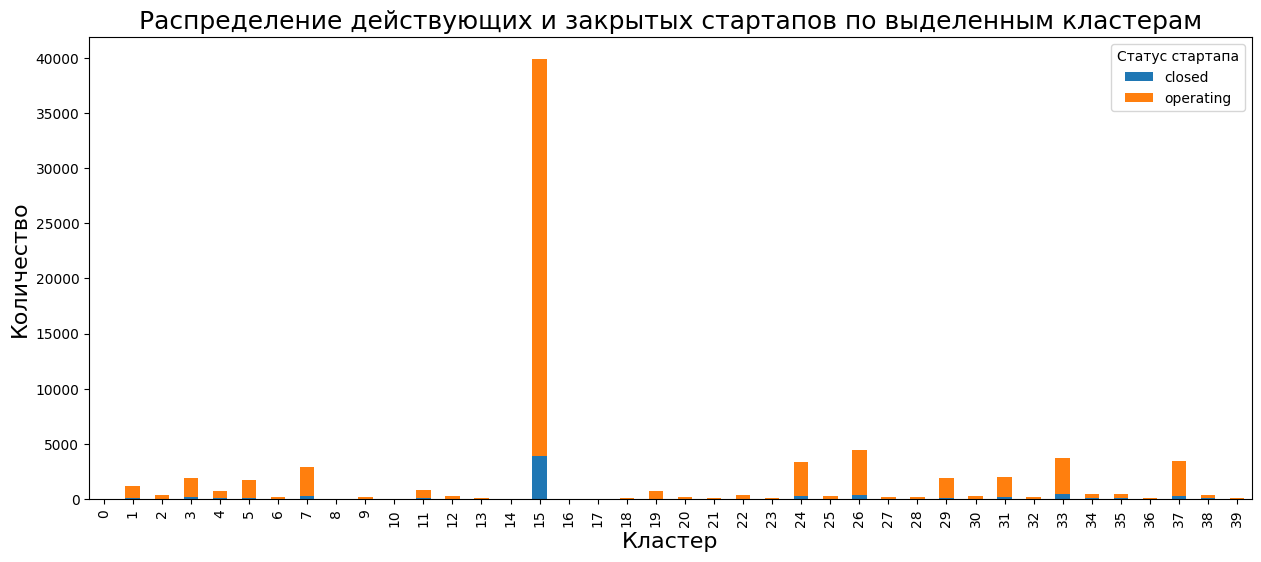

In [ ]:
# распределение действующих и закрытых стартапов по кластерам
names_of_clusters = [str(i) for i in range(40)]
data_train.groupby('status')[names_of_clusters].agg(sum)

pivot_table = data_train.groupby('status')[names_of_clusters].agg(sum).T
pivot_table.plot(kind='bar', stacked=True, figsize=(15, 6))
plt.title('Распределение действующих и закрытых стартапов по выделенным кластерам',
          fontsize=TITLE_SIZE)
plt.xlabel('Кластер', fontsize=LABEL_SIZE)
plt.ylabel('Количество', fontsize=LABEL_SIZE)
plt.legend(title='Статус стартапа')
plt.show()

Заметим наличие кластера с категориями, которые встречаются намного чаще остальных.

Рассмотрим процент закрытия стартапов в каждом кластере.

In [ ]:
pivot_table = pivot_table.reset_index()
pivot_table.columns = ['cluster', 'closed', 'operating']
pivot_table['percentage_of_closed'] = pivot_table['closed'] / (
    pivot_table['operating'] + pivot_table['closed']) * 100
clusters = clusters.reset_index()
clusters['cluster'] = clusters['cluster'].astype(str)
result_df = pd.merge(pivot_table, clusters, on='cluster', how='left')
result_df.sort_values(by='percentage_of_closed')

,cluster,closed,operating,percentage_of_closed,category
16,16,0,1,0.000,[rural energy]
14,14,0,25,0.000,[coffee]
10,10,0,1,0.000,[vulnerability management]
8,8,0,2,0.000,[enterprise purchasing]
2,2,14,323,4.154,"[b2b, b2b express delivery]"
25,25,10,227,4.219,"[developer apis, developer tools]"
32,32,7,157,4.268,"[personal branding, personal data, personal finance, personal health]"
22,22,18,379,4.534,"[clean energy, energy, energy efficiency, energy it, energy management, energy storage, industrial energy efficiency]"
19,19,35,646,5.140,"[custom retail, retail, retail technology, specialty retail]"
12,12,16,278,5.442,[brand marketing]


Повторим кластеризацию для тестового датасета.

In [ ]:
# Векторизуем категории тестового набора с помощью того же векторизатора
test_categories_df = pd.DataFrame(set_of_categories_test, columns=['category'])
X_test = vectorizer.transform(test_categories_df['category'])  # Векторизация тестовых категорий

# Прогнозируем кластеры для тестового набора
test_categories_df['cluster'] = kmeans.predict(X_test)

category_to_cluster = dict(zip(test_categories_df['category'],
                               test_categories_df['cluster']))
def convert_category_to_cluster_test(row):
    set_of_categories = set(row['category_list'].split('|'))  # Разделяем по '|'
    set_of_clusters = {category_to_cluster[category] \
                       for category in set_of_categories \
                       if category in category_to_cluster}
    return '|'.join(map(str, sorted(set_of_clusters)))

data_test['clusters_list'] = data_test.apply(convert_category_to_cluster_test, axis=1)

In [ ]:
data_test[['category_list', 'clusters_list']].head(15)

,category_list,clusters_list
0,clean technology,24
1,hospitality,15
2,finance,15
3,software|video|video streaming,1|15
4,software,15
5,design|entertainment|games,3|11|15
6,biotechnology,15
7,health care|medical|therapeutics,15
8,software,15
9,software,15


In [ ]:
# Применение MultiLabelBinarizer к тестовому набору
data_test['clusters_list'] = data_test['clusters_list'].fillna('').str.split('|')
test_category_matrix = mlb.transform(data_test['clusters_list'])

# Создаем DataFrame для тестового набора
test_category_df = pd.DataFrame(test_category_matrix, columns=mlb.classes_)

# Соединяем с исходным DataFrame тестового набора
data_test = pd.concat([data_test, test_category_df], axis=1)
test_category_df.shape

(13125, 40)

In [ ]:
# удостоверимся, что не появились NaN
data_test.isna().sum()

,0
name,0
category_list,0
funding_total_usd,0
country_code,0
state_code,0
region,0
city,0
funding_rounds,0
first_funding_at,0
last_funding_at,0


### Расположение

Рассмотрим категориальные столбцы с адресной информацией.

In [ ]:
data_train['country_code'].nunique()

132

In [ ]:
data_train['country_code'].unique()

array(['CHE', 'unknown', 'USA', 'GBR', 'RUS', 'ESP', 'FRA', 'SWE', 'IND',
       'KOR', 'AUS', 'TWN', 'HUN', 'CAN', 'FIN', 'BRA', 'CHN', 'EGY',
       'PRT', 'CHL', 'ISR', 'SVK', 'NLD', 'ARG', 'ARE', 'JPN', 'IRL',
       'DEU', 'LBN', 'EST', 'IDN', 'BEL', 'MEX', 'DNK', 'ITA', 'GRC',
       'ROM', 'TUR', 'SGP', 'SAU', 'MYS', 'NGA', 'QAT', 'VNM', 'BGR',
       'GHA', 'UGA', 'JOR', 'AUT', 'PAK', 'NZL', 'HKG', 'ZAF', 'LVA',
       'NOR', 'HRV', 'VEN', 'PER', 'LUX', 'SVN', 'POL', 'PHL', 'NIC',
       'CZE', 'ISL', 'PAN', 'URY', 'BGD', 'MCO', 'GTM', 'THA', 'TTO',
       'UKR', 'KEN', 'CRI', 'DZA', 'LTU', 'CYM', 'MUS', 'BLR', 'SLV',
       'COL', 'MLT', 'PSE', 'BLZ', 'CYP', 'MMR', 'MKD', 'KHM', 'SRB',
       'DOM', 'BWA', 'BLM', 'PRY', 'BMU', 'TAN', 'LIE', 'UZB', 'GEO',
       'SEN', 'ALB', 'ECU', 'MOZ', 'LKA', 'LAO', 'TUN', 'HND', 'ZWE',
       'BAH', 'MDA', 'BHR', 'AZE', 'MAR', 'KWT', 'IRN', 'GGY', 'KNA',
       'PRI', 'OMN', 'KAZ', 'JAM', 'NPL', 'ARM', 'RWA', 'BRN', 'JEY',
       'GIB', 'S

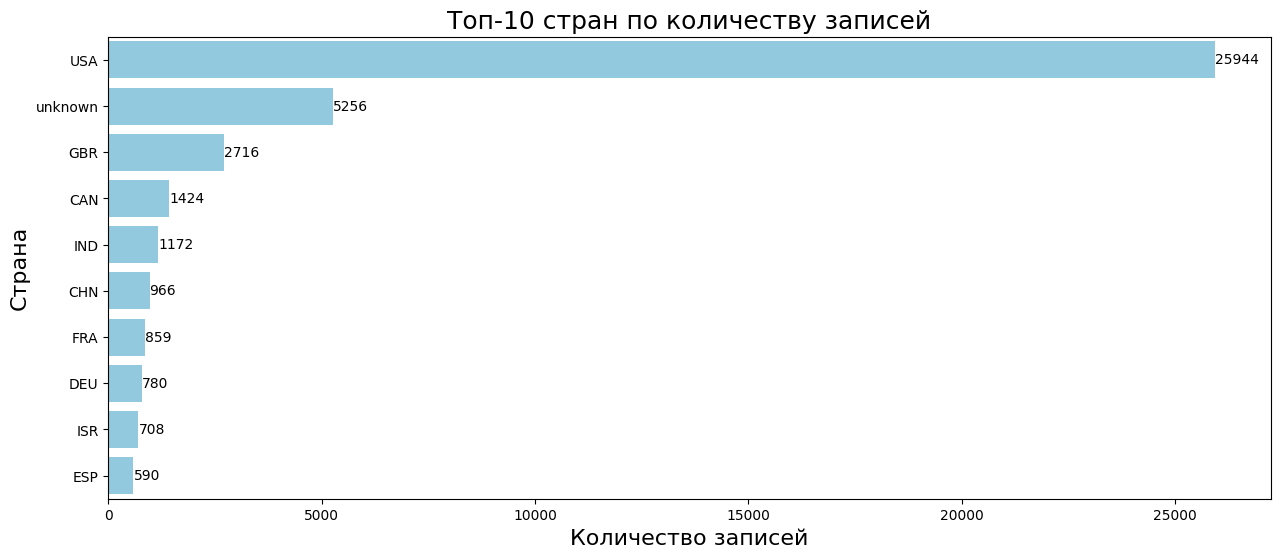

In [ ]:
# Получаем 10 стран с наибольшим количеством записей
top_10_countries = data_train['country_code'].value_counts().head(10)

# Построение горизонтального бар-графика
plt.figure(figsize=(15, 6))
sns.barplot(x=top_10_countries.values, y=top_10_countries.index, color='skyblue')

# Подписи
for index, value in enumerate(top_10_countries):
    plt.text(value, index, str(value), color='black', va='center')

plt.xlabel('Количество записей', fontsize=LABEL_SIZE)
plt.ylabel('Страна', fontsize=LABEL_SIZE)
plt.title('Топ-10 стран по количеству записей', fontsize=TITLE_SIZE)
plt.show()

In [ ]:
# Получаем 10 стран с наибольшим количеством записей для тестового датасета
data_test['country_code'].value_counts().head(10)

,count
country_code,
USA,7428
unknown,1382
GBR,725
CAN,369
IND,307
CHN,301
DEU,237
FRA,213
ISR,190


In [ ]:
df = data_train['country_code'].value_counts().reset_index()
df[df['count'] < 10].shape[0]

63

Признак 'country_code' содержит 131 уникальное значение для кодов стран (без учета unknown), записанное в трехбуквеной системе. Наибольшее число записей для USA - больше 50% тренировочных данных. 5256 записей получили значение по умолчанию unknown. Также большее число записей для следующих стран: Великобритания, Канада, Индия, Китай, Франция, Германия, Израиль, Испания. Стоит отметить наличие большого числа стран, по которым имеется малое количество записей. Для 63 стран записей меньше 10.

Топ-10 стран по количеству записей в тестовом наборе аналогичен тренировочному.

Построим сводную таблицу по этим данным. Отберем страны, по которым есть 100 и более записей, из них выберем топ-10 по наибольшему и наименьшему проценту закрытия.

In [ ]:
def plot_top_countries(df, title='Соотношение числа действующих и закрытых стартапов по странам'):

    # Создание графика
    plt.figure(figsize=(15, 6))
    df = df.sort_values(by='total')

    # Построение одного бара для каждой страны
    bars = plt.barh(df['country_code'],
                    df['operating'],
                    color='green', alpha=0.6, label='operating')

    # Добавляем часть для closed
    plt.barh(df['country_code'],
             df['closed'],
             left=df['operating'], color='red', alpha=0.6, label='closed')

    # Добавляем подписи
    for bar, closed, operating, share_of_closed in zip(bars,
                                                       df['closed'],
                                                       df['operating'],
                                                       df['share_of_closed']):
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height()/2,
                 f'{operating}/{closed} ({(share_of_closed * 100):.1f}%)',
                 va='center', ha='left', color='black')

    # Настройки графика
    plt.xlabel('Количество')
    plt.ylabel('Страна')
    plt.title(title)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.legend(title='Статус стартапа')
    plt.show()

In [ ]:
grouped_data = (data_train
                .groupby('country_code')
                .agg(
                    total=('status', 'count'),
                    operating=('status', lambda x: (x == 'operating').sum()),
                    closed=('status', lambda x: (x == 'closed').sum()),
                    share_of_closed=('status', lambda x: (x == 'closed').sum() / len(x))                )
                .reset_index()
               )

In [ ]:
# Отбираем топ-10 стран с наибольшей долей закрытия
top_10_countries_largest = grouped_data[grouped_data['total'] > 100].nlargest(10, 'share_of_closed').sort_values(by='share_of_closed')
top_10_countries_largest

,country_code,total,operating,closed,share_of_closed
87,NLD,353,323,30,0.085
55,ISR,708,647,61,0.086
20,CHE,231,211,20,0.087
30,DNK,235,214,21,0.089
77,MEX,112,101,11,0.098
2,ARG,148,131,17,0.115
113,SWE,347,306,41,0.118
16,BRA,335,294,41,0.122
131,unknown,5256,4026,1230,0.234
103,RUS,344,219,125,0.363


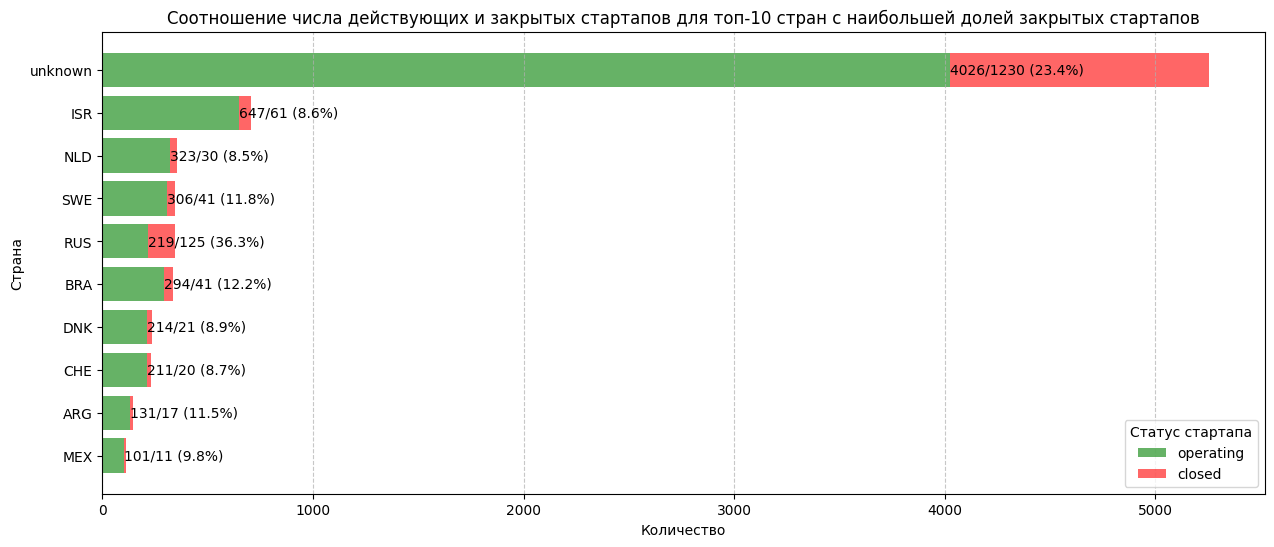

In [ ]:
plot_top_countries(
    top_10_countries_largest,
    title='Соотношение числа действующих и закрытых стартапов для топ-10 стран c наибольшей долей закрытых стартапов')

In [ ]:
# Отбираем топ-10 стран с наименьшей долей закрытия
top_10_countries_smallest = (
    grouped_data[grouped_data['total'] > 100].
    nsmallest(10, 'share_of_closed')
    .sort_values(by='share_of_closed'))
top_10_countries_smallest

,country_code,total,operating,closed,share_of_closed
21,CHL,252,244,8,0.032
51,IND,1172,1123,49,0.042
119,TUR,136,130,6,0.044
65,KOR,291,278,13,0.045
37,FIN,222,211,11,0.050
96,POL,119,113,6,0.050
22,CHN,966,917,49,0.051
60,JPN,282,267,15,0.053
107,SGP,335,316,19,0.057
8,BEL,149,140,9,0.060


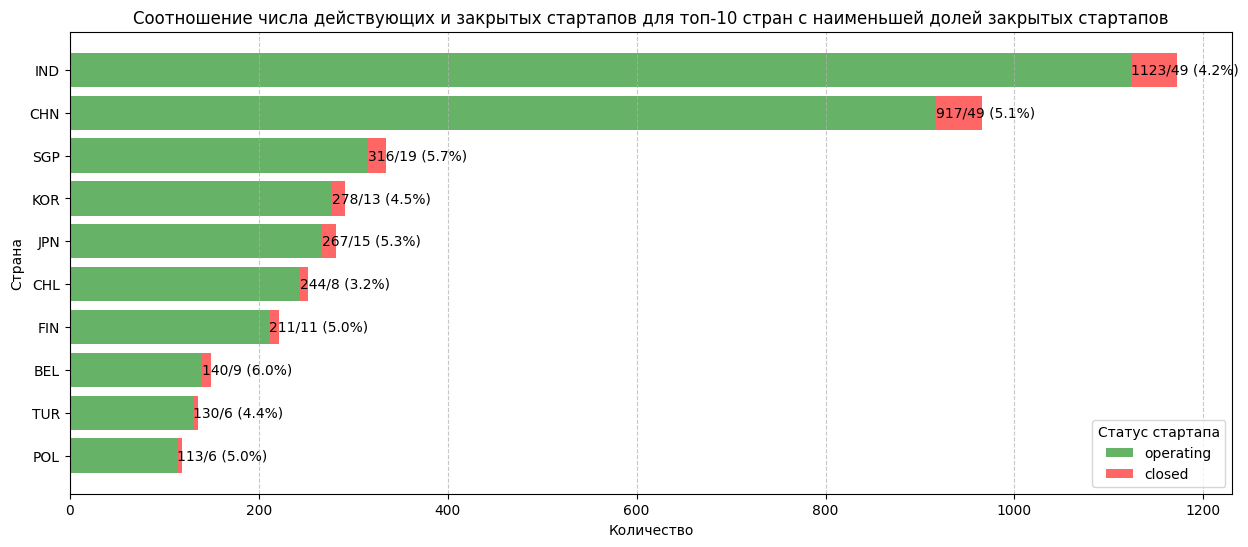

In [ ]:
plot_top_countries(
    top_10_countries_smallest,
    title='Соотношение числа действующих и закрытых стартапов для топ-10 стран с наименьшей долей закрытых стартапов')

Среди стран, по которым имеется более 100 записей, наибольший процент закрытых стартапов в России (36.3%), наименьший - в Чили(3.2%).

In [ ]:
top_10_by_startups = grouped_data.nlargest(10, 'total').sort_values(by='total')
top_10_by_startups

,country_code,total,operating,closed,share_of_closed
35,ESP,590,546,44,0.075
55,ISR,708,647,61,0.086
29,DEU,780,723,57,0.073
38,FRA,859,794,65,0.076
22,CHN,966,917,49,0.051
51,IND,1172,1123,49,0.042
19,CAN,1424,1311,113,0.079
39,GBR,2716,2495,221,0.081
131,unknown,5256,4026,1230,0.234
124,USA,25944,23890,2054,0.079


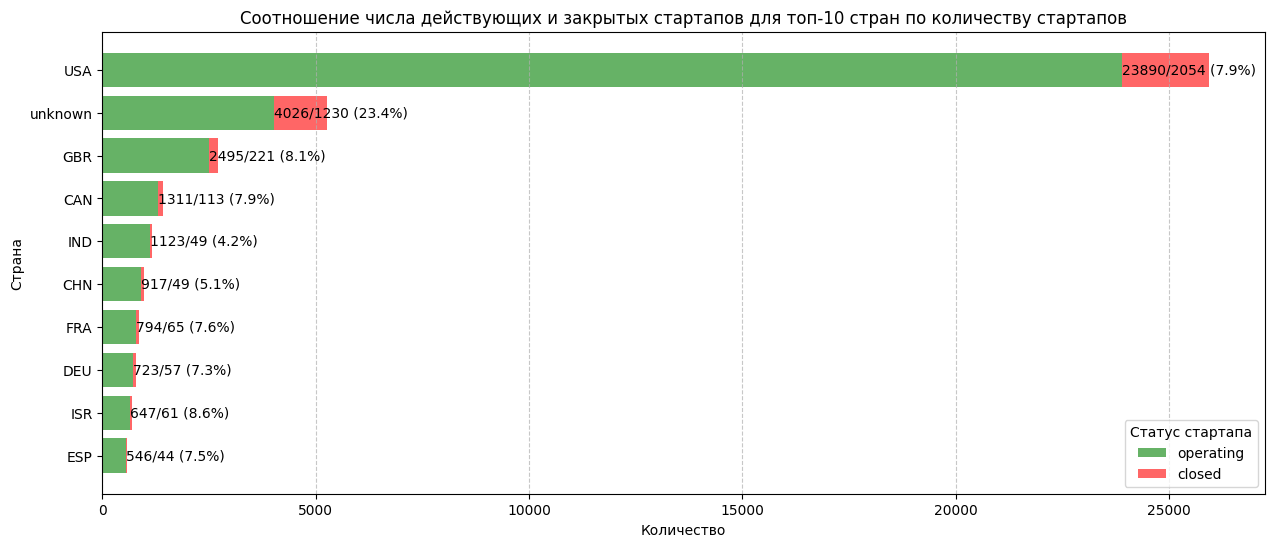

In [ ]:
plot_top_countries(
    top_10_by_startups,
    title='Соотношение числа действующих и закрытых стартапов для топ-10 стран по количеству стартапов')

Среди 10 стран с наибольшим количеством стартапов наибольший процент закрытия в Израиле (8.6%), наименьший - в Индии (4.2%).

Для укрупнения групп по адресу добавим признак 'iso_region', значение которого определим по коду страны.

In [ ]:
# Определяем регионы для каждой страны
def get_region(country_code):

    countries_by_region = {
    'North America': [
        'USA', 'CAN', 'MEX', 'BLZ', 'CRI', 'GTM', 'HND', 'NIC', 'PAN', 'SLV',
        'AIA', 'ATG', 'BHS', 'BRB', 'CUB', 'DMA', 'DOM', 'JAM', 'KNA', 'LCA',
        'VCT', 'HTI', 'TTO', 'BES', 'BLM', 'MSR', 'PRI', 'VGB', 'VIR', 'BMU',
        'UMI', 'ABW'
    ],

    'South America': [
        'ARG', 'BOL', 'BRA', 'CHL', 'COL', 'ECU', 'GUY', 'PRY', 'PER', 'SUR',
        'URY', 'VEN', 'CUW'
    ],

    'Europe': [
        'ALB', 'AND', 'AUT', 'BEL', 'BGR', 'BIH', 'BLR', 'CHE', 'CYP', 'CZE',
        'DNK', 'EST', 'FRA', 'DEU', 'GRC', 'HUN', 'ISL', 'IRL', 'ITA', 'LVA',
        'LIE', 'LTU', 'LUX', 'MKD', 'MLT', 'MCO', 'MDA', 'MNE', 'NLD', 'NOR',
        'POL', 'PRT', 'ROU', 'RUS', 'SVK', 'SVN', 'ESP', 'SWE', 'TUR', 'UKR',
        'VAT', 'GGY', 'IMN', 'JEY', 'GRL', 'FRO', 'ALA', 'HRV', 'MAF', 'REU',
        'SJM', 'SRB', 'FIN', 'GBR', 'GIB', 'GLP', 'GRD', 'GUF', 'GUM', 'HMD',
        'SMR', 'SPM', 'FLK', 'SXM'
    ],

    'Asia': [
        'AFG', 'ARM', 'AZE', 'BGD', 'BRN', 'BTN', 'CHN', 'CYP', 'GEO', 'IND',
        'IDN', 'IRN', 'IRQ', 'ISR', 'JPN', 'JOR', 'KAZ', 'KWT', 'KGZ', 'LAO',
        'LBN', 'MYS', 'MDV', 'MNG', 'MMR', 'NPL', 'OMN', 'PAK', 'PHL', 'QAT',
        'SGP', 'LKA', 'SYR', 'TJK', 'THA', 'TUR', 'TWN', 'UZB', 'VNM', 'YEM',
        'KOR', 'KHM', 'PRK', 'PSE', 'TKM', 'TLS', 'HKG', 'IOT', 'MAC', 'MYT'
    ],

    'Africa': [
        'DZA', 'AGO', 'BEN', 'BWA', 'BFA', 'BDI', 'CMR', 'CPV', 'CAF', 'TCD',
        'COM', 'DJI', 'EGY', 'GNQ', 'ETH', 'GAB', 'GHA', 'GIN', 'GMB', 'GNB',
        'KEN', 'LSO', 'LBR', 'LBY', 'MDG', 'MWI', 'MLI', 'MRT', 'MUS', 'NAM',
        'NER', 'NGA', 'RWA', 'STP', 'SEN', 'SYC', 'SLE', 'SOM', 'SSD', 'SDN',
        'SWZ', 'TGO', 'TUN', 'TZA', 'UGA', 'ZAF', 'ZMB', 'ZWE',
        'ERI', 'ESH', 'MAR', 'MOZ', 'NIU', 'NFK', 'COD', 'COG', 'CIV'
    ],

    'Oceania': [
        'AUS', 'NZL', 'FJI', 'PNG', 'SLB', 'WSM', 'TON', 'VUT', 'ASM', 'KIR',
        'NRU', 'PLW', 'TKL', 'TUV', 'NCL', 'COK', 'CCK', 'FSM', 'WLF',
        'CXR', 'CYM', 'MHL', 'MNP', 'MTQ', 'TCA', 'PYF', 'PCN'
    ],

    'Middle East': [
        'BHR', 'IRN', 'IRQ', 'ISR', 'JOR', 'KWT', 'LBN', 'OMN', 'QAT',
        'SAU', 'SYR', 'ARE', 'YEM'
    ],

    'Antarctica': [
        'ATA', 'ATF', 'BVT', 'SGS', 'SHN'
    ]}


    # Определяем регион по коду страны
    for region, countries in countries_by_region.items():
        if country_code in countries:
            return region
    return 'unknown'

In [ ]:
data_train['iso_region'] = data_train['country_code'].apply(get_region)
data_test['iso_region'] = data_test['country_code'].apply(get_region)
grouped_data = data_train['iso_region'].value_counts()
grouped_data

,count
iso_region,
North America,27525
Europe,8536
unknown,5294
Asia,4324
South America,843
Oceania,440
Africa,219
Middle East,83


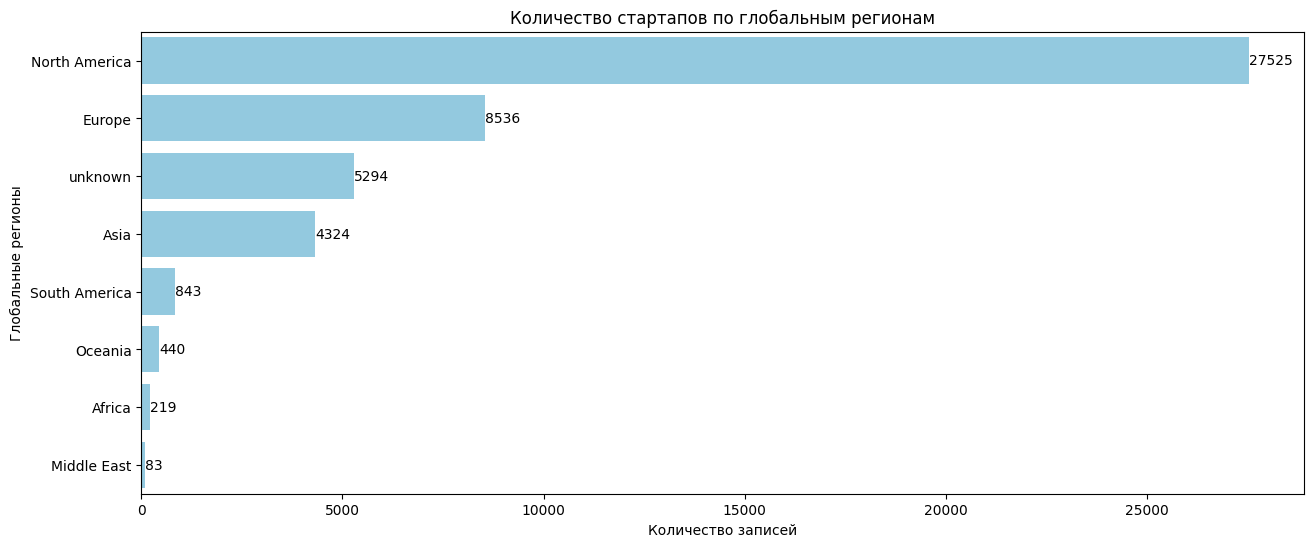

In [ ]:
# Построение горизонтального бар-графика
plt.figure(figsize=(15, 6))
sns.barplot(x=grouped_data.values, y=grouped_data.index, color='skyblue')

# Подписи
for index, value in enumerate(grouped_data):
    plt.text(value, index, str(value), color='black', va='center')

plt.xlabel('Количество записей')
plt.ylabel('Глобальные регионы')
plt.title('Количество стартапов по глобальным регионам')
plt.show()

In [ ]:
grouped_data = (
    data_train
    .groupby('iso_region')
    .agg(
        operating = ('status', lambda x: (x == 'operating').sum()),
        closed = ('status', lambda x: (x == 'closed').sum()),
        percent_of_closed = ('status', lambda x: (x == 'closed').sum() / len(x) * 100),
    )
    .reset_index()
    .sort_values(by='operating', ascending=False))
grouped_data

,iso_region,operating,closed,percent_of_closed
4,North America,25342,2183,7.931
2,Europe,7781,755,8.845
1,Asia,4075,249,5.759
7,unknown,4060,1234,23.309
6,South America,765,78,9.253
5,Oceania,402,38,8.636
0,Africa,205,14,6.393
3,Middle East,78,5,6.024


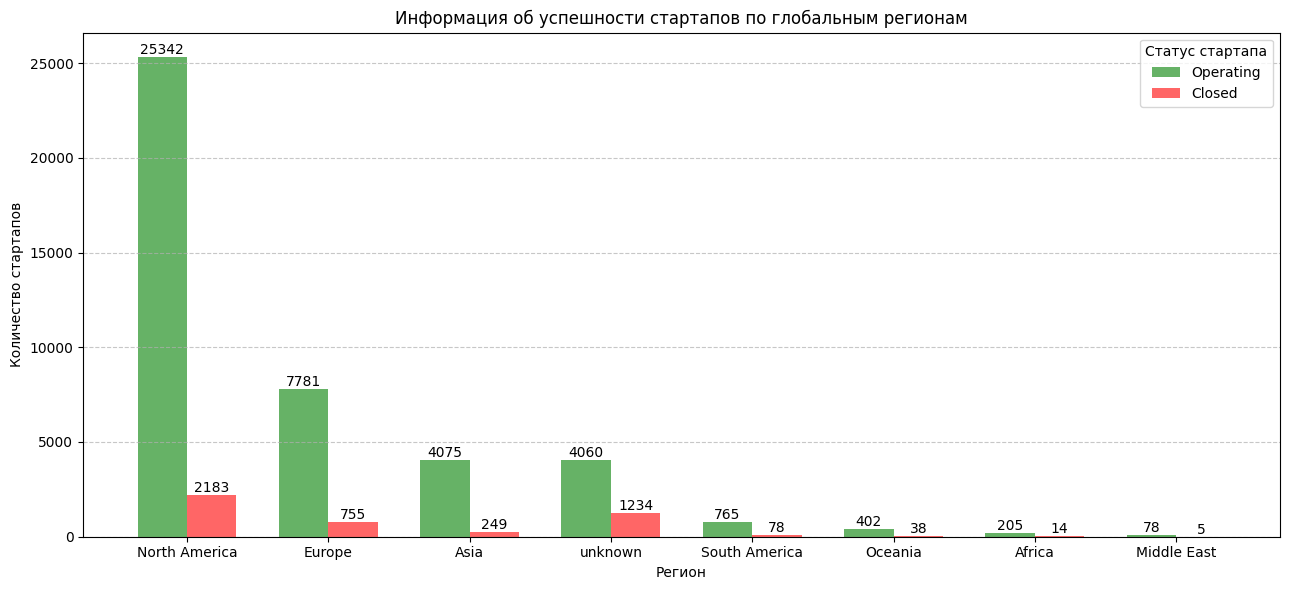

In [ ]:
plt.figure(figsize=(13, 6))
bar_width = 0.35  # Ширина баров
index = range(len(grouped_data['iso_region']))  # Индексы для баров

# Создаем бары для operating
bars1 = plt.bar(index,
                grouped_data['operating'],
                width=bar_width, label='Operating', color='green', alpha=0.6)

# Создаем бары для closed, смещаем их вправо
bars2 = plt.bar([i + bar_width for i in index],
                grouped_data['closed'],
                width=bar_width, label='Closed', color='red', alpha=0.6)

# Подписи с количеством
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    plt.text(bar1.get_x() + bar1.get_width() / 2, bar1.get_height(),
             str(bar1.get_height()),
             ha='center', va='bottom', color='black')
    plt.text(bar2.get_x() + bar2.get_width() / 2, bar2.get_height(),
             str(bar2.get_height()),
             ha='center', va='bottom', color='black')

plt.xlabel('Регион')
plt.ylabel('Количество стартапов')
plt.title('Информация об успешности стартапов по глобальным регионам')
plt.xticks([i + bar_width / 2 for i in index], grouped_data['iso_region'])
plt.legend(title='Статус стартапа')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
# сравнение укрупненных регионов по сумме финансирования
grouped_data = (
    data_train
    .groupby('iso_region')['funding_total_usd']
    .agg(['count', 'median', 'mean', 'min', 'max'])
    .sort_values(by='median', ascending=False)
    )

grouped_data.style.format("{:,.0f}")

,count,median,mean,min,max
iso_region,,,,,
North America,"27,525","1,000,000","4,052,588",1,"27,901,875"
Asia,"4,324","878,596","3,934,367",6,"27,804,097"
Africa,219,"860,000","1,891,697","1,000","27,200,000"
Europe,"8,536","860,000","2,787,295",5,"27,900,945"
Oceania,440,"860,000","2,967,219","3,000","25,775,000"
unknown,"5,294","860,000","2,236,387",63,"27,730,000"
Middle East,83,"540,000","1,510,708","2,000","27,460,000"
South America,843,"155,033","1,207,517","1,000","26,499,973"


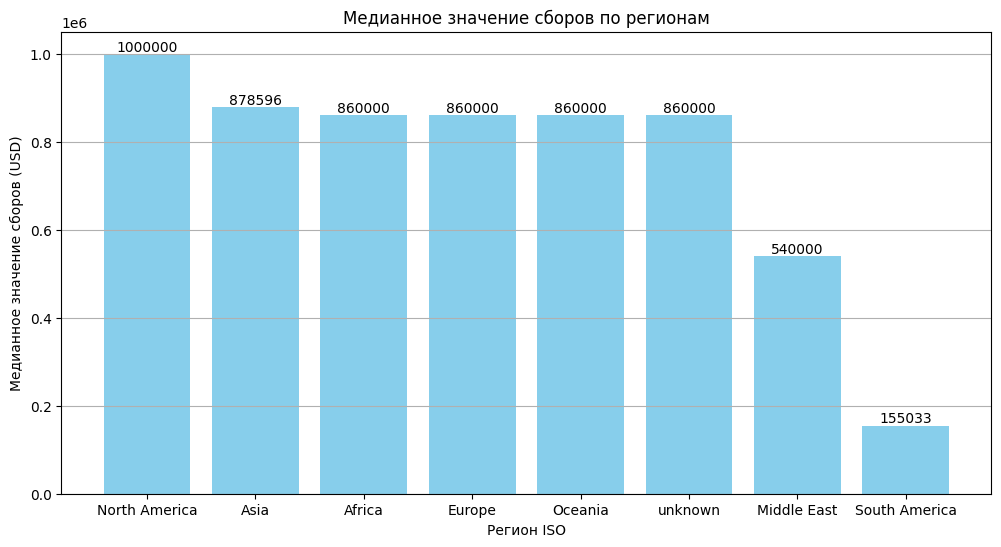

In [ ]:
# Настройка столбчатой диаграммы
plt.figure(figsize=(12, 6))
bars = plt.bar(grouped_data.index, grouped_data['median'], color='skyblue')
plt.title('Медианное значение сборов по регионам')
plt.xlabel('Регион ISO')
plt.ylabel('Медианное значение сборов (USD)')
plt.grid(axis='y')  # Добавление сетки по оси Y

# Добавление значений столбцов на диаграмму
for bar in bars:
    yval = bar.get_height()  # Получение высоты (значения) столбца
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.0f}',
             ha='center', va='bottom')


plt.show()

Наибольшая медианная общая сумма финансирования наблюдается в Северной Америке(1,000,000 USD), наименьшая - в Южной Америке(155,033 USD). Максимальные суммы сборов близки по значению.

Продолжим рассматривать признаки, связанные с местоположением.

In [ ]:
data_train['state_code'].nunique()

298

In [ ]:
data_train['region'].nunique()

1022

In [ ]:
data_train['city'].nunique()

4352

Признак 'state_code' содержит 298 уникальных значения, 'region' - 1022, 'city' - 4352. Будем учитывать такое большое число категорий при выборе моделей и признаков для них.

In [ ]:
data_train['state_code'].unique()

array(['25', 'unknown', 'VA', 'NJ', 'TX', 'OR', 'FL', 'WA', 'NY', 'C7',
       'AZ', '91', 'GA', 'CA', 'MA', 'PA', '56', 'MN', 'A8', 'DE', '26',
       'Q5', '7', 'RI', '11', 'C5', 'CO', '3', '1', 'ON', 'IL', 'OH',
       'K2', '2', '14', '23', '30', 'H9', 'AL', '29', '6', 'NC', '12',
       '22', '5', 'MI', '48', 'ND', '40', 'VT', '16', '4', 'UT', 'IN',
       '8', '9', '18', 'MD', 'CT', '13', 'NV', '10', 'B8', '27', '17',
       'IA', 'WI', 'L9', 'NM', 'B7', 'MO', 'BC', '21', 'F7', 'ME', 'NH',
       '35', 'NS', 'C1', 'C3', 'SC', '20', 'TN', 'A6', '51', 'I7', 'LA',
       'KS', '42', 'N7', 'U8', 'I2', 'AR', '41', 'QC', 'AB', '37', '15',
       '19', '97', 'V2', 'D2', 'A7', 'C9', 'F8', 'Y2', 'B9', 'J7', 'M9',
       'G2', 'H3', 'NB', '28', 'V8', '34', 'B5', 'F2', 'A9', 'NE', 'Z7',
       '53', 'H8', 'MT', 'ID', 'MB', 'DC', 'KY', '61', '60', 'B4', '82',
       'A2', 'C8', 'L3', 'D9', 'M3', 'MS', '31', '33', '52', 'HI', 'AK',
       '78', '72', 'Q4', 'Y4', 'WY', '32', 'Q3', 'F9', '24', 

In [ ]:
# Подсчет уникальных стран для каждого штата
unique_countries_per_state = (data_train
                              .groupby('state_code')['country_code']
                              .nunique()
                              .reset_index())
unique_countries_per_state.columns = ['state_code', 'unique_country_count']
unique_countries_per_state

,state_code,unique_country_count
0,1,26
1,10,17
2,11,17
3,12,14
4,13,18
...,...,...
293,Y9,1
294,Z1,1
295,Z7,1
296,Z8,1


Можем увидеть, что одинаковые коды штатов могут быть в разных странах.

### Даты и время

Изучим созданный признак lifetime.

In [ ]:
data_train['lifetime'].describe()

,lifetime
count,"47,264.000"
mean,"2,976.961"
std,"2,057.525"
min,19.000
25%,"1,675.000"
50%,"2,376.000"
75%,"3,653.000"
max,"17,378.000"


In [ ]:
data_test['lifetime'].describe()

,lifetime
count,"13,125.000"
mean,"3,097.610"
std,"2,128.357"
min,52.000
25%,"1,726.000"
50%,"2,526.000"
75%,"3,866.000"
max,"17,167.000"


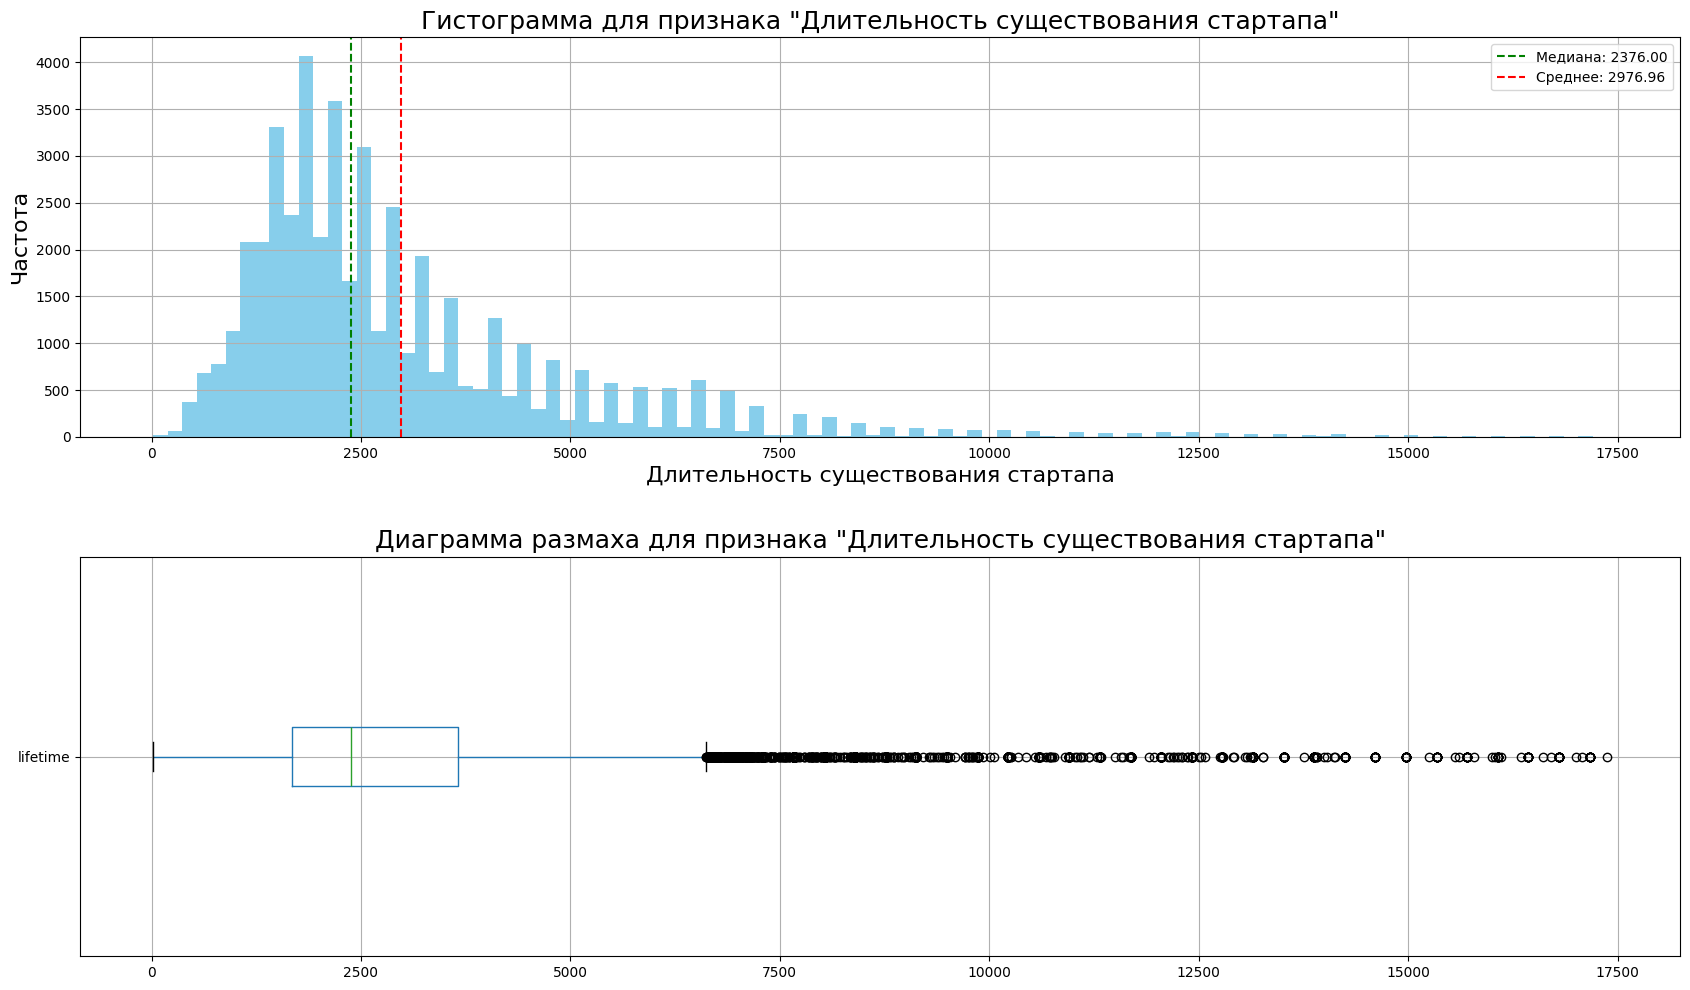

In [ ]:
analyze_numerical_data(data_train, 'lifetime', 'Длительность существования стартапа')

Среднее значение продолжительности существования стартапа составляет 2 976.961 дня. Стандартное отклонение равно 2 057.525, что говорит о разбросе значений относительно среднего. Минимальное значение - 19 дней, а максимальное значение достигает 17 378. Межквартильный размах - от 1 675 до 3 653. Медиана равна 2 376.  Распределение данных тренировочной и тестовой выборки в целом похожее.

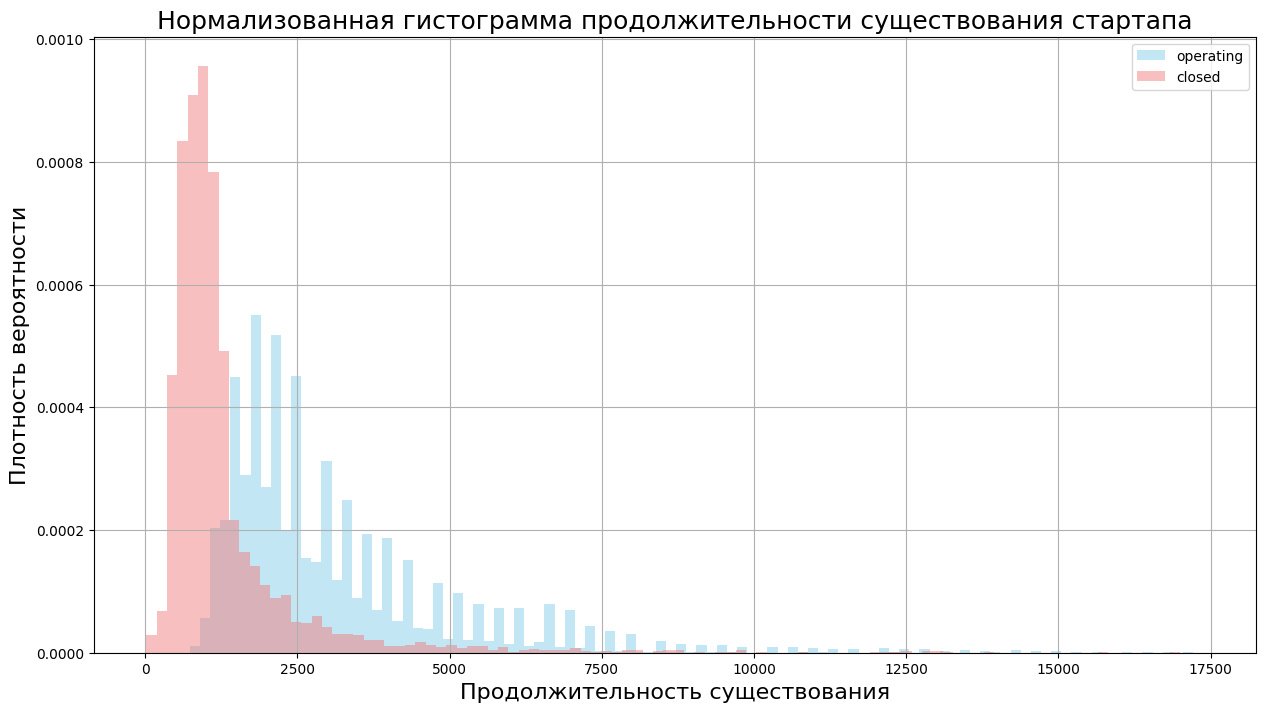

In [ ]:
plt.figure(figsize=(15, 8))

# Построение гистограммы для действующих стартапов
plt.hist(
    data_train[data_train['status'] == 'operating']['lifetime'],
    bins=100, color='skyblue', alpha=0.5, label='operating', density=True)
# Построение гистограммы для закрытых стартапов
plt.hist(
    data_train[data_train['status'] == 'closed']['lifetime'],
    bins=100, color='lightcoral', alpha=0.5, label='closed', density=True)

plt.title('Нормализованная гистограмма продолжительности существования стартапа',
          fontsize=TITLE_SIZE)
plt.xlabel('Продолжительность существования', fontsize=LABEL_SIZE)
plt.ylabel('Плотность вероятности', fontsize=LABEL_SIZE)
plt.legend()
plt.grid(True)
plt.legend()
plt.show()

Используем даты финансирования для создания нового столбца, содержащего разницу в днях между первым и последним финансированием компании. Также выделим год, месяц и день из имеющихся дат.

In [ ]:
data_train['days_between_first_and_last_funding'] = (
    data_train['last_funding_at'] - data_train['first_funding_at']).dt.days
data_test['days_between_first_and_last_funding'] = (
    data_test['last_funding_at'] - data_test['first_funding_at']).dt.days

In [ ]:
def extract_date_features(df, date_column_prefix):
    """Извлекает год, месяц и день из даты и добавляет их в DataFrame."""
    df[f'{date_column_prefix}_year'] = df[f'{date_column_prefix}_at'].dt.year
    df[f'{date_column_prefix}_month'] = df[f'{date_column_prefix}_at'].dt.month
    df[f'{date_column_prefix}_day'] = df[f'{date_column_prefix}_at'].dt.day

# Извлекаем характеристики для обоих столбцов
extract_date_features(data_train, 'first_funding')
extract_date_features(data_train, 'last_funding')
extract_date_features(data_test, 'first_funding')
extract_date_features(data_test, 'last_funding')

In [ ]:
(
    data_train
    .groupby('status')['lifetime']
    .agg(['median', 'min', 'max'])
    .sort_values(by='median', ascending=False)
)

,median,min,max
status,,,
operating,"2,557.000",731,17378
closed,983.500,19,17004


Медианная продолжительность существования у действующих стартапов значительно превышает этот показатель у закрытых.

__Промежуточный вывод__:
- Наблюдается дисбаланс классов в целевом признаке `status`( 9.36% стартапов закрыты, 90.64% - действующие).
- Для признака `funding_total_usd` выявили наличие выбросов, удалили значения, превышающие 27 928 437.5 (размер тренировочного датасета сократился на 10%). После удаления распределение следующее: значения распределены в диапазоне от 1 до 27 901 875, границы межквартильного размаха - от 450 000 до 3 900 000,  медианное значение - 860 000, среднее - 3 534 501.005, стандартное отклонение - 5 559 262.804.
- Средняя общая сумма финансирования у закрытых компаний меньше (3 073 640.330 против 3 583 664.657), в то время как медианные значения равны. Минимальная и максимальная общие суммы практически равны.
- Большинство компаний прошли только через один раунд финансирования (68.3%), 2 раунда (18.8%) или 3 раунда (7.5%). Среднее число раундов у действующих компаний незначительно больше, чем у закрытых. Медианные значения равны. Наибольшая доля закрытий приходится на компании, прошедшие только 1 или 2 раунда финансирования (11.2% и 7.5% соответственно), наименьшая - у компаний, прошедших 5 раундов (3.6%) (исследовали раунды, по которым есть более 100 записей).
- В столбце 'category_list' фигурируют 855 уникальных категорий. Провели разделение категорий на 40 кластеров и создали 40 дополнительных признаков (есть ли в списке категорий такие, которые относятся к выделенному кластеру). Провели эту же процедуру для тестового датасета.
- Признак 'country_code' содержит 131 уникальное значение для кодов стран. Наибольшее число записей для USA - больше 50% тренировочных данных. Также большее число записей для следующих стран: Великобритания, Канада, Индия, Китай, Франция, Германия, Израиль, Испания. Для большого числа стран имеется малое количество записей (для 63 стран записей меньше 10).
- Среди стран, по которым имеется более 100 записей, наибольший процент закрытых стартапов в России (36.3%), наименьший - в Чили(3.2%).
- Среди 10 стран с наибольшим количеством стартапов наибольший процент закрытия в Израиле (8.6%), наименьший - в Индии (4.2%).
- Для укрупнения групп по местоположению добавили признак 'iso_region'. Наибольшее количество стартапов наблюдается в Северной Америке, наименьшее - в странах Среднего Востока. Наибольшая медианная общая сумма финансирования наблюдается в Северной Америке(1,000,000 USD), наименьшая - в Южной Америке(155,033 USD). Максимальные суммы сборов близки по значению.
- Среднее значение продолжительности существования стартапа составляет 2 976.961 дня. Стандартное отклонение равно 2 057.525, что говорит о разбросе значений относительно среднего. Минимальное значение - 19 дней, а максимальное значение достигает 17 378. Межквартильный размах - от 1 675 до 3 653. Медиана равна 2 376.
- Были созданы новые признаки: разница в днях между первым и последним финансированием компании, год, месяц и день первого и последнего финансирования.
- Значительных различий в распределении данных тренировочной и тестовой выборки не выявлено.

## Корреляционный анализ

In [ ]:
data_train['clusters_list'] = data_train['clusters_list'].apply(lambda x: '|'.join(x))

Не будем рассматривать признаки, которые содержат слишком много уникальных значений из-за времени вычисления. Также исключим признаки, которые мы использовали для создания новых признаков, и те ,которые не оказывают влияния на таргет.

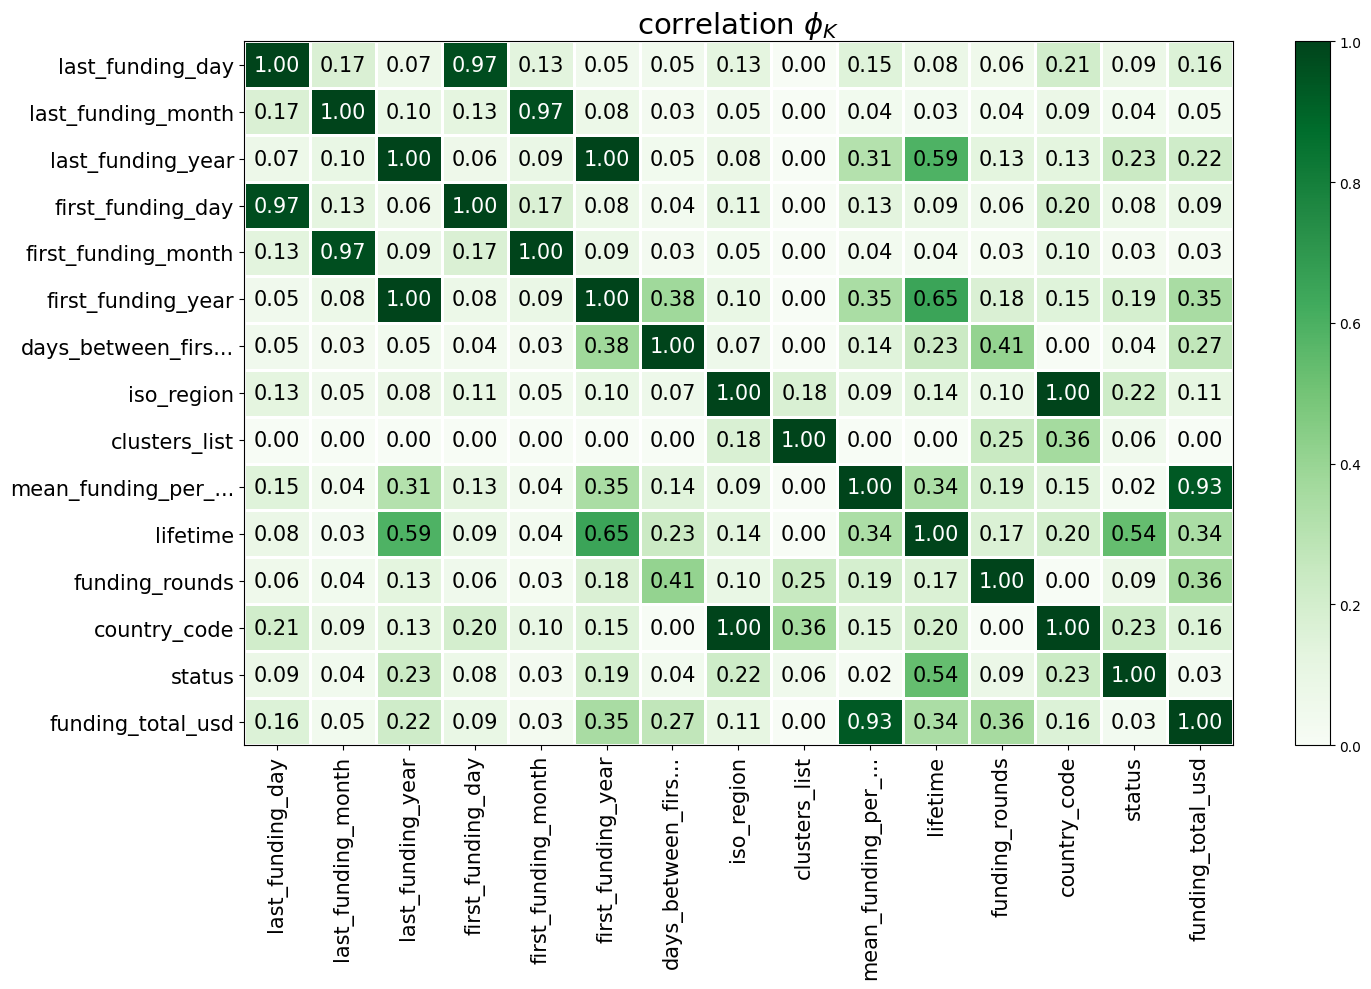

In [ ]:
col_to_drop = names_of_clusters + \
 ['name', 'category_list', 'state_code', 'region', 'city',
  'founded_at', 'first_funding_at', 'last_funding_at', 'closed_at']

num_col_names = data_train.drop(columns=col_to_drop).select_dtypes(
    include='number').columns.tolist()

phik_overview = phik_matrix(
    data_train.drop(columns=col_to_drop), interval_cols=num_col_names)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(15, 10)
)

Согласно матрице корреляции наблюдаем:
- заметная взаимосвязь (0.5-0.7) таргета с признаком lifetime
- слабая взаимосвязь (0.1 - 0.3): last_funding_year, first_funding_year, iso_region, country_code
- корреляция меньше 0.1:
last_funding_day,
last_funding_month,
first_funding_day,
first_funding_month,
days_between_first_and_last_funding,
clusters_list,
funding_rounds,
mean_funding_per_round,
funding_total_usd

Наблюдается мультиколлинеарность между признаками:
- last_funding_day и first_funding_day,
- last_funding_month и first_funding_month,
-  last_funding_year и first_funding_year,
-  iso_region и country_code,
-  funding_total_usd и mean_funding_per_year.

Признак mean_funding_per_round использовать не будем. Также попробуем для начала использовать location_state.

__Промежуточный вывод__:
- построили матрицу корреляции между признаками;
- наблюдается заметная взаимосвязь между таргетом и признаком 'lifetime', слабая - с признаками last_funding_year, first_funding_year, iso_region, country_code; коэффициент корреляции меньше 0.1 с признаками last_funding_day, last_funding_month, first_funding_day, first_funding_month, days_between_first_and_last_funding, clusters_list, funding_rounds, mean_funding_per_round, funding_total_usd;
- присутствует мультиколлинеарность между признаками, содержащими первый и последний день/месяц/год финансирвоания (при моделировании будем использовать последнюю дату финансирования, т.к. коэффициенты корреляции с целевым признаком выше), между funding_total_usd и mean_funding_per_year (будем использовать funding_total_usd), между iso_region и country_code.


## Создание модели

Перед нами стоит задача бинарной классификации, обучение с учителем, дисбаланс классов в целевой переменной.

### CatBoost

Для начала попробуем выполнить моделирование с использованием CatBoost. Учитывая его способность хорошо справляться с категориальными данными, не будем использовать для него созданные для каждого кластера столбцы.

In [ ]:
# снова приведем значения в столбце clusters_list к строке
data_train['clusters_list'] = (
    data_train['clusters_list']
    .apply(lambda x: '|'.join(x) if isinstance(x, list) else x))
data_test['clusters_list'] = (
    data_test['clusters_list']
    .apply(lambda x: '|'.join(x) if isinstance(x, list) else x))

Попробуем поэксперементировать с параметрами country_code, iso_region, category_list, clusters_list.

In [ ]:
# включен список кластеров, код страны, укрупненный регион
cat_features = ['country_code',
       'state_code', 'region', 'city', 'funding_rounds',
       'clusters_list',
       'iso_region']

model_features = ['funding_total_usd', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds',
       'lifetime', 'clusters_list',
       'iso_region', 'days_between_first_and_last_funding',
       'last_funding_year', 'last_funding_month', 'last_funding_day']
target = 'status'

In [ ]:
# включен список кластеров, код страны
cat_features_v2 = ['country_code',
       'state_code', 'region', 'city', 'funding_rounds',
       'clusters_list'
       ]

model_features_v2 = ['funding_total_usd', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds',
       'lifetime', 'clusters_list',
       'days_between_first_and_last_funding',
       'last_funding_year', 'last_funding_month', 'last_funding_day']

In [ ]:
# включен список категорий, код страны, укрупненный регион
cat_features_v3 = ['country_code',
       'state_code', 'region', 'city', 'funding_rounds',
       'category_list',
       'iso_region']

model_features_v3 = ['funding_total_usd', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds',
       'lifetime', 'category_list',
       'iso_region', 'days_between_first_and_last_funding',
       'last_funding_year', 'last_funding_month', 'last_funding_day']

In [ ]:
# включен список категорий, код страны
cat_features_v4 = ['country_code',
       'state_code', 'region', 'city', 'funding_rounds',
       'category_list']

model_features_v4 = ['funding_total_usd', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds',
       'lifetime', 'category_list',
       'days_between_first_and_last_funding',
       'last_funding_year', 'last_funding_month', 'last_funding_day']

Первая модель

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
    data_train[model_features],
    data_train[target],
    test_size=TEST_SIZE,
    stratify = data_train[target],
    random_state=RANDOM_STATE)

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
valid_pool = Pool(data=X_valid, label=y_valid, cat_features=cat_features)

model = CatBoostClassifier(iterations=1000,
                           learning_rate=0.1,
                           depth=6,
                           loss_function='Logloss',
                           eval_metric='F1',
                           random_seed=RANDOM_SEED,
                            thread_count=1 )
model.fit(train_pool, eval_set=valid_pool, verbose=False)
train_score = model.score(train_pool)
valid_score = model.score(valid_pool)

train_score, valid_score

(0.9807727909867499, 0.977255897598646)

Вторая модель

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
    data_train[model_features_v2],
    data_train[target],
    test_size=TEST_SIZE,
    stratify = data_train[target],
    random_state=RANDOM_STATE)

train_pool_v2 = Pool(data=X_train, label=y_train, cat_features=cat_features_v2)
valid_pool_v2 = Pool(data=X_valid, label=y_valid, cat_features=cat_features_v2)

model_v2 = CatBoostClassifier(iterations=1000,
                           learning_rate=0.1,
                           depth=6,
                           loss_function='Logloss',
                           eval_metric='F1',
                           random_seed=RANDOM_SEED,
                           thread_count=1)
model_v2.fit(train_pool_v2, eval_set=valid_pool_v2, verbose=False)
train_score_v2 = model_v2.score(train_pool_v2)
valid_score_v2 = model_v2.score(valid_pool_v2)

train_score_v2, valid_score_v2

(0.9836026553119462, 0.9778906167354279)

Третья модель

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
    data_train[model_features_v3],
    data_train[target],
    test_size=TEST_SIZE,
    stratify = data_train[target],
    random_state=RANDOM_STATE)

train_pool_v3 = Pool(data=X_train, label=y_train, cat_features=cat_features_v3)
valid_pool_v3 = Pool(data=X_valid, label=y_valid, cat_features=cat_features_v3)

model_v3 = CatBoostClassifier(iterations=1000,
                           learning_rate=0.1,
                           depth=6,
                           loss_function='Logloss',
                           eval_metric='F1',
                           random_seed=RANDOM_SEED,
                           thread_count=1)
model_v3.fit(train_pool_v3, eval_set=valid_pool_v3, verbose=False)
train_score_v3 = model_v3.score(train_pool_v3)
valid_score_v3 = model_v3.score(valid_pool_v3)

train_score_v3, valid_score_v3

(0.9840522599243606, 0.9782079763038188)

Четвертая модель

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
    data_train[model_features_v4],
    data_train[target],
    test_size=TEST_SIZE,
    stratify = data_train[target],
    random_state=RANDOM_STATE)

train_pool_v4 = Pool(data=X_train, label=y_train, cat_features=cat_features_v4)
valid_pool_v4 = Pool(data=X_valid, label=y_valid, cat_features=cat_features_v4)

model_v4 = CatBoostClassifier(iterations=1000,
                           learning_rate=0.1,
                           depth=6,
                           loss_function='Logloss',
                           eval_metric='F1',
                           random_seed=RANDOM_SEED,
                           thread_count=1)
model_v4.fit(train_pool_v4, eval_set=valid_pool_v4, verbose=False)
train_score_v4 = model_v4.score(train_pool_v4)
valid_score_v4 = model_v4.score(valid_pool_v4)

train_score_v4, valid_score_v4

(0.984396075216207, 0.9778906167354279)

Модели показывают близкий результат на валидационной выборке. Остановимся на 3 модели (0.9782).

### Другие модели

Попробуем построить другие модели: DecisionTreeClassifier, KNeighborsClassifier, LogisticRegression, RandomForestClassifier. Для них будем использовать созданные ранее новые признаки (40 признаков для кластеров) вместо списка категорий/кластеров. Такие категориальные признаки как город, штат, регион учитывать не будем.

In [ ]:
ohe_columns = ['country_code', 'iso_region']
num_columns =  ['funding_total_usd', 'funding_rounds', 'lifetime',
                'days_between_first_and_last_funding','last_funding_year',
                'last_funding_month', 'last_funding_day']

In [ ]:
data_train.duplicated(subset=ohe_columns + num_columns).sum()

359

In [ ]:
data_train = data_train.drop_duplicates(subset=ohe_columns + num_columns, keep='last')
data_train.shape[0]/data_train_check.shape[0]

0.8931563713915759

In [ ]:
# выделяем признаки и целевую переменную
X = data_train.drop(['name', 'category_list', 'status', 'state_code',
                     'region', 'city', 'founded_at', 'closed_at',
                     'clusters_list','first_funding_at', 'last_funding_at',
                     'first_funding_year','mean_funding_per_round',
                     'first_funding_month', 'first_funding_day' ], axis = 1)
y = data_train['status']

# выделим выборки с учетом страт
X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y)

X_train.shape, X_valid.shape

((37524, 49), (9381, 49))

In [ ]:
# общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', OneHotEncoder(drop='first', sparse_output=False,
                              handle_unknown='ignore'), ohe_columns),
        ('num', MinMaxScaler(), num_columns)
    ],
    remainder = 'passthrough'
)

# итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

In [ ]:
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(4, 7),
        'models__min_samples_leaf': [1, 2, 4],
        'models__class_weight': ['balanced'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(3, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear'
        )],
        'models__C': [0.1, 1, 10],
        'models__class_weight': ['balanced'],
        'models__penalty': ['l1', 'l2'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [50, 100, 200],
        'models__max_depth': [5, 10, 15, 20],
        'models__min_samples_leaf': [2, 5, 10],
        'models__class_weight': ['balanced'],
    }
]

In [ ]:
f1_weighted_scorer = make_scorer(f1_score, pos_label='operating', average='weighted')

start = time.time()

randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    scoring=f1_weighted_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

randomized_search_time = time.time() - start

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print('Метрика лучшей модели при кросс-валидации:', randomized_search.best_score_)
print('Время поиска лучших параметров:', randomized_search_time, 'секунд')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['country_code',
                                                   'iso_region']),
                                                 ('num', MinMaxScaler(),
                                                  ['funding_total_usd',
                                                   'funding_rounds', 'lifetime',
                                                   'days_between_first_and_last_funding',
                                                   'last_funding_year',
                                           

In [ ]:
results = randomized_search.cv_results_
results_df = pd.DataFrame(results)

# Отсортируем результаты по mean_valid_score и получим 10 лучших моделей
top_10_results = results_df.nlargest(10, 'mean_test_score')

# Выводим 10 лучших моделей
print("\n10 лучших моделей:")
print(top_10_results[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']])


10 лучших моделей:
                                                                                                                                                                                      params  \
1        {'preprocessor__num': MinMaxScaler(), 'models__min_samples_leaf': 2, 'models__max_depth': 6, 'models__class_weight': 'balanced', 'models': DecisionTreeClassifier(random_state=42)}   
5         {'preprocessor__num': 'passthrough', 'models__min_samples_leaf': 4, 'models__max_depth': 6, 'models__class_weight': 'balanced', 'models': DecisionTreeClassifier(random_state=42)}   
8        {'preprocessor__num': MinMaxScaler(), 'models__min_samples_leaf': 1, 'models__max_depth': 5, 'models__class_weight': 'balanced', 'models': DecisionTreeClassifier(random_state=42)}   
4      {'preprocessor__num': StandardScaler(), 'models__min_samples_leaf': 1, 'models__max_depth': 4, 'models__class_weight': 'balanced', 'models': DecisionTreeClassifier(random_state=42)}   
7               {'mo

В топ-4 только DecisionTreeClassifier. Отклонение у лучших моделей одинаковое. Останавливаем свой выбор на той модели, которую определил RandomizedSearchCV.

In [ ]:
print('F1 модели на валидационной выборке:',
      f'{f1_score(y_valid, randomized_search.predict(X_valid), pos_label="operating"):.5f}')

F1 модели на валидационной выборке: 0.97784


### Проверка модели на адекватность (сравнение с Dummy)

In [ ]:
from sklearn.dummy import DummyClassifier

# выделяем признаки и целевую переменную
X = data_train.drop(['name', 'category_list', 'status', 'state_code',
                     'region', 'city', 'founded_at', 'closed_at',
                     'clusters_list','first_funding_at', 'last_funding_at',
                     'first_funding_year','mean_funding_per_round',
                     'first_funding_month', 'first_funding_day' ], axis = 1)
y = data_train['status']

# выделим выборки с учетом страт
X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y)

# создайте и обучите DummyClassifier на тренировочных данных
# выполните предсказание на тестовой выборке
dummy_model = DummyClassifier(random_state=RANDOM_STATE)
dummy_model.fit(X_train, y_train)
dummy_model_preds = dummy_model.predict(X_valid)

# посчитайте и выведите F1-меру
dummy_f1 = f1_score(y_valid, dummy_model_preds, pos_label='operating')
print('F1-score =', round(dummy_f1,2))

F1-score = 0.95


### Итоговая оценка качества предсказания лучшей модели

Лучшей моделью оказалась модель CatBoostClassifier c параметрами: iterations=1000, learning_rate=0.1, depth=6, loss_function='Logloss', eval_metric='F1', random_seed=123 и признаками  'funding_total_usd', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds',
       'lifetime', 'category_list',
       'iso_region', 'days_between_first_and_last_funding',
       'last_funding_year', 'last_funding_month', 'last_funding_day'.

 Получим предсказания для тестового датасета для проверки на kaggle.

In [ ]:
test_pool = Pool(data=data_test[model_features_v3],
                 cat_features=cat_features_v3)
test_pred = model_v3.predict(test_pool)
rez = pd.DataFrame(test_pred, columns=['status'])

combined_df = pd.concat([data_test['name'], rez], axis=1)
combined_df.head()
combined_df.to_csv('final_submission.csv', index=False)

Значение метрики на тестовом датасете: 0.87489.
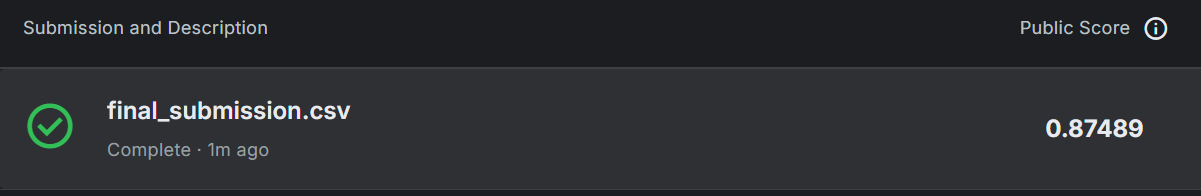

__Промежуточный вывод__:
- мы исследовали модели CatBoost с разными наборами входных признаков и модели DecisionTreeClassifier, KNeighborsClassifier, LogisticRegression, RandomForestClassifier с разными наборами гиперпараметров;
- Лучшей моделью оказалась модель CatBoostClassifier c параметрами: iterations=1000, learning_rate=0.1, depth=6, loss_function='Logloss', eval_metric='F1', random_seed=123 и признаками 'funding_total_usd', 'country_code', 'state_code', 'region', 'city', 'funding_rounds', 'lifetime', 'category_list', 'iso_region', 'days_between_first_and_last_funding', 'last_funding_year', 'last_funding_month', 'last_funding_day';
- Итоговая оценка качества лучшей модели (F1-метрика): 0.87489.

## Анализ важности признаков

Проведем анализ важности признаков с использованием SHAP.

In [ ]:
explainer = shap.TreeExplainer(model_v3)

In [ ]:
shap_values = explainer.shap_values(train_pool_v3)

Визуализируем общий вклад признаков в прогнозы модели.

In [ ]:
# повторим разбивку для построения графика
X_train, X_valid, y_train, y_valid = train_test_split(
    data_train[model_features_v3],
    data_train[target],
    test_size=TEST_SIZE,
    stratify = data_train[target],
    random_state=RANDOM_STATE)

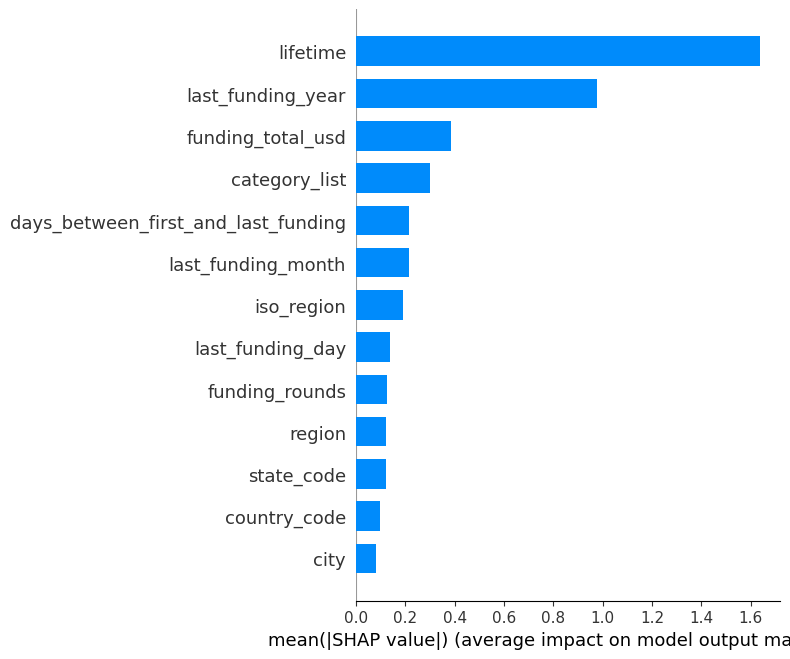

In [ ]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

Наибольший вклад в предсказания вносят признаки `lifetime`, `last_funding_year`. Наименее важными являются `city`, `country_code`, `state_code`, `region`.

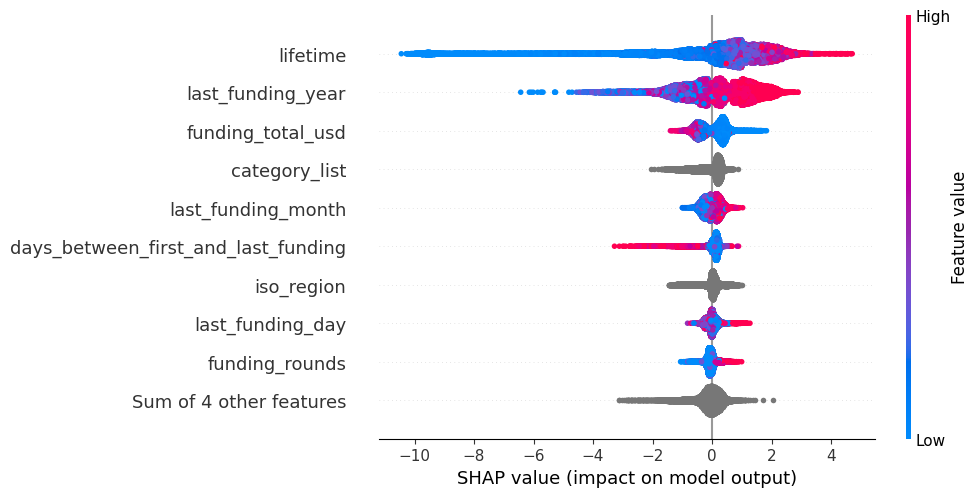

In [ ]:
shap.plots.beeswarm(explainer(X_train))

Признаки, влияющие на модель,в порядке убывания влияния:
- lifetime (низкие значения склоняют предсказание к классу 'closed', более высокие - к 'operating')
- last_funding_year (низкие значения склоняют предсказание к классу 'closed', более высокие - к 'operating')
- funding_total_usd (более высокие значения склоняют предсказание к классу 'closed')
- category_list
- last_funding_month (низкие значения склоняют предсказание к классу 'closed', более высокие - к 'operating')
- days_between_first_and_last_funding (более высокие значения склоняют предсказание к классу 'closed')
- iso_region
- last_funding_day(высокие значения склоняют к 'operating')
- founding_rounds (однозначно не интерпретируется)
- country_code, state_code, region, city

Получается, что шансы на то, что стартап функционирует, повышаются, если:
- высокий показатель длительности существования
- финансирование было не так давно (от даты выгрузки)
- общая сумма полученного финансирования не высока
- прошло не много времени между первым и последним финансированием
- последнее финансирование было получено ближе к концу года

__Промежуточный вывод__:

Наибольший вклад в предсказания вносят признаки lifetime, last_funding_year. Также важными являются funding_total_usd и category_list. Наименее важными являются country_code, state_code, region, city.

## Вывод

Мы исследовали данные об успешности стартапов. Загрузили тренировочный и тестовый датасеты, убедились, что они соответствуют описанию.

В тренировочных данных присутствовало большое количество пропущенных значений. Пропуски были заполнены подходящими для каждого признака значениями (значением по умолчанию, медианой, медианой по группам).

Провели __исследовательский анализ данных__. Было выявлено наличие выбросов. Провели очистку данных, чтобы сделать их более однородными.
Наблюдения, полученные в ходе анализа (дробные значения округлены до целого):
- 9.36% стартапов закрыты, 90.64% - действующие.
- Значения общей суммы сборов распределены в диапазоне от 1 до 27 901 875, границы межквартильного размаха - от 450 000 до 3 900 000,  медианное значение - 860 000, среднее - 3 534 501, стандартное отклонение - 5 559 263.
- Среднее значение продолжительности существования стартапа составляет 2 977 дней. Стандартное отклонение равно 2 058 (большой разброс значений относительно среднего). Минимальное значение - 19 дней, а максимальное значение достигает 17 378. Межквартильный размах - от 1 675 до 3 653. Медиана равна 2 376.
- Средняя общая сумма финансирования у закрытых компаний меньше (3 073 640 USD против 3 583 665 USD), в то время как медианные значения равны. Минимальная и максимальная общие суммы практически равны.
- 68.3% компаний прошли только через один раунд финансирования, 18.8% компаний - через 2 раунда, 7.5% - через 3 раунда. Среднее число раундов у действующих компаний незначительно больше, чем у закрытых. Медианные значения равны. Наибольшая доля закрытий приходится на компании, прошедшие только 1 или 2 раунда финансирования (11.2% и 7.5% соответственно), наименьшая - у компаний, прошедших 5 раундов (3.6%) (исследовали раунды, по которым есть более 100 записей).
- представлено 855 уникальных категорий направления деятельности стартапов,
- Более 50% данных - это информация о стартапах США. Также большее количество стартапов в следующих стран: Великобритания, Канада, Индия, Китай, Франция, Германия, Израиль, Испания.
- Среди стран, по которым имеется более 100 записей, наибольший процент закрытых стартапов в России (36.3%), наименьший - в Чили(3.2%).
- Наибольшее количество стартапов наблюдается в Северной Америке, наименьшее - в странах Среднего Востока. Наибольшая медианная общая сумма финансирования наблюдается в Северной Америке(1 000 000 USD), наименьшая - в Южной Америке(155 033 USD). Максимальные суммы сборов близки по значению.
- Значительных различий в распределении данных тренировочной и тестовой выборки не выявлено.

Мы создали следующие признаки:
- для укрупнения групп по местоположению добавили признак 'iso_region',
- разница в днях между первым и последним финансированием компании,
- год, месяц и день первого и последнего финансирования,
- список кластеров и 40 признаков, отражающих, относится ли категория деятельности стартапа к конкретному кластеру,
- среднее значение финансирования, полученного за один раунд.

Провели __корреляционный анализ признаков__. Выявили заметную взаимосвязь между таргетом и признаком 'lifetime', слабая - с признаками last_funding_year, first_funding_year, iso_region, country_code, с остальными признаками - коэффициент корреляции меньше 0.1. Определили наличие мультиколлинеарных признаков: признаки, содержащие первый и последний день/месяц/год финансирования, funding_total_usd и mean_funding_per_year, iso_region и country_code.

Перед нами стояла __задача бинарной классификации с дисбалансом классов, обучение с учителем__. Мы провели ряд экспериментов, исследовали модели CatBoost с разными наборами входных признаков и модели DecisionTreeClassifier, KNeighborsClassifier, LogisticRegression, RandomForestClassifier с разными наборами гиперпараметров.

Лучшей моделью оказалась модель __CatBoostClassifier c параметрами: iterations=1000, learning_rate=0.1, depth=6, loss_function='Logloss', eval_metric='F1', random_seed=123__, и признаками _'funding_total_usd', 'country_code', 'state_code', 'region', 'city', 'funding_rounds', 'lifetime', 'category_list', 'iso_region', 'days_between_first_and_last_funding', 'last_funding_year', 'last_funding_month', 'last_funding_day';_;
Итоговая оценка качества лучшей модели __(F1-метрика): 0.87489__.

Провели анализ важности признаков. Наибольший вклад в предсказания построенной нами модели вносят признаки lifetime, last_funding_year. Также важными являются funding_total_usd и category_list. Наименьшее влияние оказывают country_code, state_code, region, city.

Можем сделать вывод, что шансы на то, что стартап функционирует, повышаются, если он уже функционирует длительное время, недавно получал финансирование, но, при этом, общая сумма полученного финансирования не является высокой, между первым и последним финансированием не прошло много времени и последнее финансирование было получено ближе к концу года.